## 🌐 Connect Colab to Google Drive

In [ ]:
GOOGLE = True

try:
    from google.colab import drive
    drive.mount("/gdrive")
    %cd /gdrive/My Drive
    %cd ANDL_HOMEWORK2_LINK
    home_path = "./models/"
    GOOGLE = True
except:
    home_path = "./"
    GOOGLE = False

print(f"GOOGLE: {GOOGLE}")
print(f"HOME: {home_path}")

Mounted at /gdrive
/gdrive/My Drive
/gdrive/.shortcut-targets-by-id/1vsTygZGT_kAzNeU8X79sw_R-6RcOwzqm/Homework 2
GOOGLE: True
HOME: ./models/enrico


## DATASET PATHS

In [ ]:
AUGN = 7

# Dataset Training
trainset_filename = f"{home_path}/dataset/training_{AUGN}.npz"

# Dataset Validation
validation_filename = f"{home_path}/dataset/validation_{AUGN}.npz"

# Dataset Test
testset_filename = f"{home_path}/dataset/test.npz"

ID = 7

## ⚙️ Import Libraries

In [ ]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

from tensorflow.keras import mixed_precision

# Enable mixed precision training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

TensorFlow version: 2.17.1
Keras version: 3.5.0
GPU devices: 1


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## ⏳ Load the Data

In [ ]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 80

# Set maximum number of training epochs
EPOCHS = 1000

REDUCE_CL0_FACTOR = 2

REDUCE_CL4_FACTOR = 7

In [ ]:
# Take datasets
# Add color channel and rescale pixels between 0 and 1
training_data = np.load(trainset_filename)
X_train = training_data["images"]
X_train = X_train[..., np.newaxis] / 255.0
y_train = training_data["labels"]
y_train = y_train[..., np.newaxis]
del training_data

validation_data = np.load(validation_filename)
X_val = validation_data["images"]
X_val = X_val[..., np.newaxis] / 255.0
y_val = validation_data["labels"]
y_val = y_val[..., np.newaxis]
del validation_data

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")

Training X shape: (18032, 64, 128, 1)
Training y shape: (18032, 64, 128, 1)


In [ ]:
INPUT_SHAPE = (64,128,1)
NUM_CLASSES = 5

print(f"Input shape: {INPUT_SHAPE}")
print(f"Number of classes: {NUM_CLASSES}")

Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [ ]:
import numpy as np
from collections import Counter

def compute_segmentation_class_weights(masks, num_classes):
    flat_labels = masks.flatten()

    # Unique classes
    classes = np.unique(range(num_classes))

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=flat_labels)

    # Convert to a dictionary for easy access
    class_weight_dict = dict({(int(i)): float(weight) for i, weight in zip(classes, class_weights)})

    return class_weight_dict

In [ ]:
# Example usage
cl_w_dict = {0: 0.05, 1: 1, 2: 0.8, 3: 1, 4: 5}

print(cl_w_dict)

{0: 0.05, 1: 1, 2: 0.8, 3: 1, 4: 5}


In [ ]:
def generate_patches(images, labels):
    # Split into patches
    patches_images = []
    patches_labels = []
    for img, lbl in zip(images, labels):
        # Split image and label into 4 patches (2 rows x 2 columns)
        img_patches = [
            img[:32, :64], img[:32, 64:],
            img[32:, :64], img[32:, 64:]
        ]
        lbl_patches = [
            lbl[:32, :64], lbl[:32, 64:],
            lbl[32:, :64], lbl[32:, 64:]
        ]

        # Add the channel dimension back
        patches_images.extend([patch for patch in img_patches])
        patches_labels.extend([patch for patch in lbl_patches])

    # Convert to numpy arrays
    patches_images = np.array(patches_images)
    patches_labels = np.array(patches_labels)

    return patches_images, patches_labels

def recombine_patches(patches_images, patches_labels):
    """
    Combines patches of size (32, 64, 1) into images and labels of size (64, 128, 1).

    Args:
        patches_images (numpy.ndarray): Array of image patches of shape (N*4, 32, 64, 1).
        patches_labels (numpy.ndarray): Array of label patches of shape (N*4, 32, 64, 1).

    Returns:
        tuple: A tuple containing:
            - images (numpy.ndarray): Array of combined images of shape (N, 64, 128, 1).
            - labels (numpy.ndarray): Array of combined labels of shape (N, 64, 128, 1).
    """
    # Validate inputs
    if len(patches_images) % 4 != 0 or len(patches_labels) % 4 != 0:
        raise ValueError("Number of patches must be a multiple of 4")

    num_images = len(patches_images) // 4
    combined_images = []
    combined_labels = []

    for i in range(num_images):
        # Extract 4 patches for the current image/label
        img_patches = patches_images[i * 4:(i + 1) * 4]
        lbl_patches = patches_labels[i * 4:(i + 1) * 4]

        # Combine patches into a single image/label
        top_row_img = np.concatenate((img_patches[0], img_patches[1]), axis=1)
        bottom_row_img = np.concatenate((img_patches[2], img_patches[3]), axis=1)
        full_img = np.concatenate((top_row_img, bottom_row_img), axis=0)

        top_row_lbl = np.concatenate((lbl_patches[0], lbl_patches[1]), axis=1)
        bottom_row_lbl = np.concatenate((lbl_patches[2], lbl_patches[3]), axis=1)
        full_lbl = np.concatenate((top_row_lbl, bottom_row_lbl), axis=0)

        # Append the combined image/label
        combined_images.append(full_img)
        combined_labels.append(full_lbl)

    # Convert to numpy arrays
    combined_images = np.array(combined_images)
    combined_labels = np.array(combined_labels)

    return combined_images, combined_labels

In [ ]:
PATCHED = 0
if PATCHED:
  X_train, y_train = generate_patches(X_train, y_train)
  X_val, y_val = generate_patches(X_val, y_val)
  INPUT_SHAPE = (32,64,1)

## 🛠️ Train and Save the Model

In [ ]:
class InstanceNormalization(tfk.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon

    def build(self, input_shape):
        # Create trainable parameters: gamma (scale) and beta (shift)
        self.gamma = self.add_weight(
            shape=(input_shape[-1],),
            initializer="ones",
            trainable=True,
            name="gamma"
        )
        self.beta = self.add_weight(
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
            name="beta"
        )
        super(InstanceNormalization, self).build(input_shape)

    def call(self, inputs):
        # Compute mean and variance across spatial dimensions (axis 1, 2)
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        # Normalize the input
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        # Apply scale (gamma) and shift (beta)
        return self.gamma * normalized + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super(InstanceNormalization, self).get_config()
        config.update({
            "epsilon": self.epsilon
        })
        return config

def squeeze_excite_block(input_tensor, ratio=16):
    """Squeeze-and-Excitation block."""
    channel_axis = -1  # Assuming channels-last format
    filters = input_tensor.shape[channel_axis]

    se = tfkl.GlobalAveragePooling2D()(input_tensor)
    se = tfkl.Reshape((1, 1, filters))(se)
    se = tfkl.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = tfkl.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    return tfkl.Multiply()([input_tensor, se])

class LearnableDenoisingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LearnableDenoisingLayer, self).__init__(**kwargs)
        # Initialize learnable Gaussian filter weights
        self.gaussian_weights = self.add_weight(
            shape=(5, 5, 1, 1),
            initializer="random_normal",
            trainable=True,
            name="gaussian_weights"
        )
        self.gaussian_bias = self.add_weight(
            shape=(1,),
            initializer="zeros",
            trainable=True,
            name="gaussian_bias"
        )

        # Initialize learnable anisotropic filter weights
        self.anisotropic_weights = self.add_weight(
            shape=(3, 3, 1, 1),
            initializer="random_normal",
            trainable=True,
            name="anisotropic_weights"
        )
        self.anisotropic_bias = self.add_weight(
            shape=(1,),
            initializer="zeros",
            trainable=True,
            name="anisotropic_bias"
        )

    def call(self, inputs):
        # Ensure the input has the shape (64, 128, 1)
        if inputs.shape[1:] != (64, 128, 1):
            raise ValueError("Input shape must be (64, 128, 1)")

        # Gaussian Denoising with learnable filters
        gaussian_denoised = tf.nn.conv2d(
            inputs,
            filters=self.gaussian_weights,
            strides=1,
            padding="SAME"
        ) + self.gaussian_bias

        # Anisotropic Denoising with learnable filters
        anisotropic_denoised = tf.nn.conv2d(
            inputs,
            filters=self.anisotropic_weights,
            strides=1,
            padding="SAME"
        ) + self.anisotropic_bias

        # Concatenate the original, Gaussian denoised, and anisotropic denoised images
        concatenated = tf.concat([inputs, gaussian_denoised, anisotropic_denoised], axis=-1)
        return concatenated

def unet_block(input_tensor, filters, kernel_size=3, activation='leaky_relu', stack=2, name='', drop=0.0, ratio=16):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_initializer='he_normal', kernel_regularizer=tfk.regularizers.l2(0.01), name=name + 'conv' + str(i + 1))(x)
        x = InstanceNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
        if ratio != 0:
            x = squeeze_excite_block(x, ratio)

    if drop != 0.0:
            x = tfkl.Dropout(drop)(x)

    # Return the transformed tensor
    return x

In [ ]:
def get_unet_model(input_shape, num_classes, seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    denoising = LearnableDenoisingLayer()(input_layer)

    down_block_1 = unet_block(denoising, 64, stack=2, name='db_1_')
    down_size_1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(down_size_1, 128,stack=2,  name='db_2_', drop=0.1)
    down_size_2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(down_size_2, 256, stack=2, name='db_3_', drop=0.1)
    down_size_3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(down_size_3, 512, stack=2, name='db_4_a', drop=0.2)

    down_size_4 = tfkl.MaxPooling2D()(down_block_4)

    down_block_5 = unet_block(down_size_4, 1024, stack=2, name='db_5_', drop = 0.3)

    up_size_a_1 = tfkl.UpSampling2D()(down_block_2)
    collect_a_1 = tfkl.Concatenate()([up_size_a_1, down_block_1])
    up_block_a_1 = unet_block(collect_a_1, 64, stack=2, name='ub_a_1_', drop=0.1)

    up_size_b_1 = tfkl.UpSampling2D()(down_block_3)
    collect_b_1 = tfkl.Concatenate()([up_size_b_1, down_block_2])
    up_block_b_1 = unet_block(collect_b_1, 128, stack=2, name='ub_b_1_', drop=0.2)

    up_size_c_1 = tfkl.UpSampling2D()(down_block_4)
    collect_c_1 = tfkl.Concatenate()([up_size_c_1, down_block_3])
    up_block_c_1 = unet_block(collect_c_1, 256, stack=2, name='ub_c_1_', drop=0.2)

    up_size_d_1 = tfkl.UpSampling2D()(down_block_5)
    collect_d_1 = tfkl.Concatenate()([up_size_d_1, down_block_4])
    up_block_d_1 = unet_block(collect_d_1, 512, stack=2, name='ub_d_1_', drop=0.2)

    up_size_b_2 = tfkl.UpSampling2D()(up_block_b_1)
    collect_b_2 = tfkl.Concatenate()([up_size_b_2, up_block_a_1])
    up_block_b_2 = unet_block(collect_b_2, 64, stack=2, name='ub_b_2_', drop=0.1)

    up_size_c_2 = tfkl.UpSampling2D()(up_block_c_1)
    collect_c_2 = tfkl.Concatenate()([up_size_c_2, up_block_b_1])
    up_block_c_2 = unet_block(up_size_c_2, 128, stack=2, name='ub_c_2_', drop=0.2)

    up_size_d_2 = tfkl.UpSampling2D()(up_block_d_1)
    collect_d_2 = tfkl.Concatenate()([up_size_d_2, up_block_c_1])
    up_block_d_2 = unet_block(collect_d_2, 256, stack=2, name='ub_d_2_', drop=0.2)

    up_size_c_3 = tfkl.UpSampling2D()(up_block_c_2)
    collect_c_3 = tfkl.Concatenate()([up_size_c_3, up_block_b_2])
    up_block_c_3 = unet_block(collect_c_3, 64, stack=2, name='ub_c_3_', drop=0.1)

    up_size_d_3 = tfkl.UpSampling2D()(up_block_d_2)
    collect_d_3 = tfkl.Concatenate()([up_size_d_3, up_block_c_2])
    up_block_d_3 = unet_block(collect_d_3, 128, stack=2, name='ub_d_3_')

    up_size_d_4 = tfkl.UpSampling2D()(up_block_d_3)
    collect_d_4 = tfkl.Concatenate()([up_size_d_4, up_block_c_3])
    up_block_d_4 = unet_block(up_size_d_4, 64, stack=2, name='ub_d_4_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(up_block_d_4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
model = get_unet_model(INPUT_SHAPE, NUM_CLASSES, seed=seed)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=False, show_trainable=True)

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ cast (Cast)            │ (None, 64, 128, 1)   │            0 │ input_layer[0][0]   │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ learnable_denoising_l… │ (None, 64, 128, 3)   │           36 │ cast[0][0]          │    Y    │
│ (LearnableDenoisingLa… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ db_1_conv1 (Conv2D)    │ (None, 64, 128, 64)  │        1,792 │ learnable_denoisin… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ db_1_bn1               │ (None, 64, 128, 64)  │          128 │ db_1_conv1[0][0]    │    Y    │
│ (InstanceNormalizatio… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ db_1_activation1       │ (None, 64, 128, 64)  │            0 │ db_1_bn1[0][0]      │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 64)           │            0 │ db_1_activation1[0… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ reshape (Reshape)      │ (None, 1, 1, 64)     │            0 │ global_average_poo… │    -    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense (Dense)          │ (None, 1, 1, 4)      │          256 │ reshape[0][0]       │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_1 (Dense)        │ (None, 1, 1, 64)     │          256 │ dense[0][0]         │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ multiply (Multiply)    │ (None, 64, 128, 64)  │            0 │ db_1_activation1[0… │    -    │
│                        │                      │              │ dense_1[0][0]       │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ db_1_conv2 (Conv2D)    │ (None, 64, 128, 64)  │       36,928 │ multiply[0][0]      │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ db_1_bn2               │ (None, 64, 128, 64)  │          128 │ db_1_conv2[0][0]    │    Y    │
│ (InstanceNormalizatio… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ db_1_activation2       │ (None, 64, 128, 64)  │            0 │ db_1_bn2[0][0]      │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ global_average_poolin… │ (None, 64)           │            0 │ db_1_activation2[0… │    -    │
│ (GlobalAveragePooling… │                      │              │                     │         │
├──────────────────────

 Total params: 34,614,825 (132.05 MB)

 Trainable params: 34,614,825 (132.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the statecshpc1024
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5, imgs=5, recall=1):
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency
        self.imgs = imgs
        self.recall = recall

        self.lastR = []
        for i in range(imgs):
            self.lastR.append(random.randint(0, len(self.images)))

        self.colormap = create_segmentation_colormap(5)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs

            for i in range(self.recall):
                newR = random.randint(0, len(self.images))
                self.lastR.append(newR)
                self.lastR.pop(0)

            plt.figure(figsize=(10, 5))

            for i, idx in enumerate(self.lastR):
                image = self.images[idx]
                label = self.labels[idx]

                image = tf.expand_dims(image,0)
                label = tf.expand_dims(label,0)

                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()

                plt.subplot(3, self.imgs, i + 1)
                plt.imshow(image[0], cmap="gray")
                plt.title("Image")
                plt.axis('off')

                plt.subplot(3, self.imgs, (1 * self.imgs) + i + 1)
                col_lbl = apply_colormap(label.numpy(), self.colormap)
                plt.imshow(col_lbl)
                plt.title("Truth")
                plt.axis('off')

                plt.subplot(3, self.imgs, (2 * self.imgs ) + i + 1)
                col_pred = apply_colormap(y_pred[0], self.colormap)
                plt.imshow(col_pred)
                plt.title("Pred")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


In [ ]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tfk.losses.SparseCategoricalCrossentropy(ignore_class=0),
    optimizer=tf.keras.optimizers.AdamW(),
    metrics=[MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


In [ ]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    mode='min',
    patience=PATIENCE,
    restore_best_weights=True
)

reduce_lr_on_plateau = tfk.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=15
)

save_checkpoint = tfk.callbacks.ModelCheckpoint(
    f'{home_path}/checkpoint/best_{ID}.keras',
    monitor='val_mean_iou',
    save_best_only=True,
    mode='max',
    verbose=1
)

viz_callback = VizCallback(X_val, y_val, frequency=3, imgs=10, recall=5)

Epoch 1/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 16.7417 - mean_iou: 0.1157

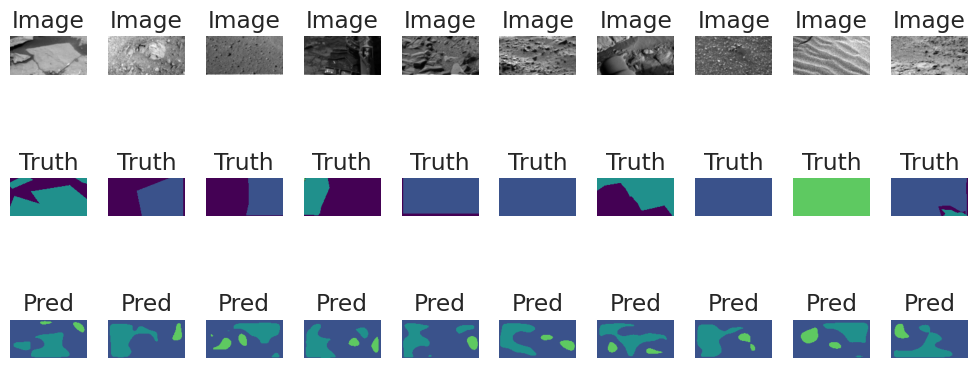


Epoch 1: val_mean_iou improved from -inf to 0.18526, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 258s 287ms/step - loss: 16.7211 - mean_iou: 0.1157 - val_loss: 1.2013 - val_mean_iou: 0.1853 - learning_rate: 0.0010
Epoch 2/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 1.2037 - mean_iou: 0.2075
Epoch 2: val_mean_iou improved from 0.18526 to 0.29744, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 112s 145ms/step - loss: 1.2036 - mean_iou: 0.2076 - val_loss: 1.0611 - val_mean_iou: 0.2974 - learning_rate: 0.0010
Epoch 3/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 1.0421 - mean_iou: 0.2699
Epoch 3: val_mean_iou did not improve from 0.29744
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 137ms/step - loss: 1.0420 - mean_iou: 0.2698 - val_loss: 0.9549 - val_mean_iou: 0.2953 - learning_rate: 0.0010
Epoch 4/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.9824 - mean_iou: 0.2779

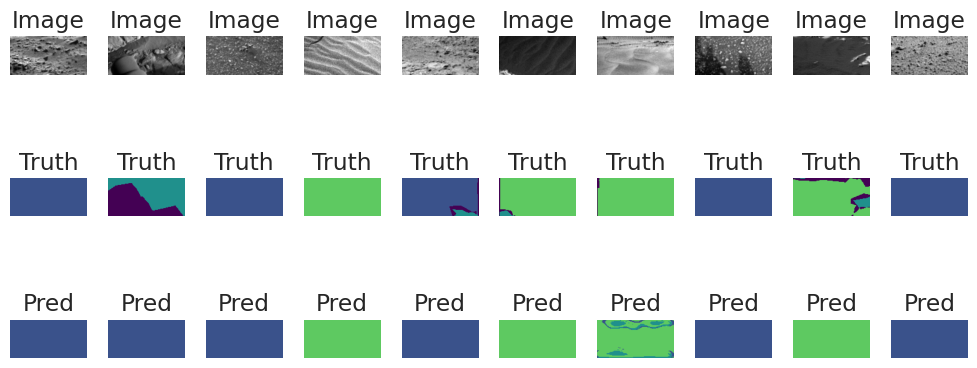


Epoch 4: val_mean_iou did not improve from 0.29744
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - loss: 0.9824 - mean_iou: 0.2778 - val_loss: 0.9640 - val_mean_iou: 0.2935 - learning_rate: 0.0010
Epoch 5/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.9722 - mean_iou: 0.2853
Epoch 5: val_mean_iou improved from 0.29744 to 0.30371, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 149ms/step - loss: 0.9721 - mean_iou: 0.2853 - val_loss: 0.9108 - val_mean_iou: 0.3037 - learning_rate: 0.0010
Epoch 6/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.9267 - mean_iou: 0.3039
Epoch 6: val_mean_iou did not improve from 0.30371
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 136ms/step - loss: 0.9267 - mean_iou: 0.3039 - val_loss: 0.9407 - val_mean_iou: 0.2901 - learning_rate: 0.0010
Epoch 7/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.9164 - mean_iou: 0.3083

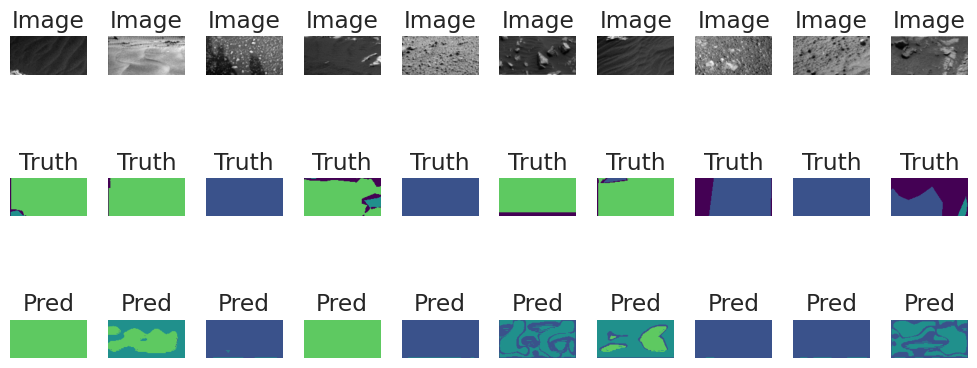


Epoch 7: val_mean_iou improved from 0.30371 to 0.33889, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 92s 155ms/step - loss: 0.9163 - mean_iou: 0.3083 - val_loss: 0.8521 - val_mean_iou: 0.3389 - learning_rate: 0.0010
Epoch 8/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.8904 - mean_iou: 0.3316
Epoch 8: val_mean_iou improved from 0.33889 to 0.34300, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 84s 150ms/step - loss: 0.8903 - mean_iou: 0.3315 - val_loss: 0.8524 - val_mean_iou: 0.3430 - learning_rate: 0.0010
Epoch 9/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.9547 - mean_iou: 0.3076
Epoch 9: val_mean_iou did not improve from 0.34300
564/564 ━━━━━━━━━━━━━━━━━━━━ 134s 136ms/step - loss: 0.9547 - mean_iou: 0.3076 - val_loss: 0.9638 - val_mean_iou: 0.3303 - learning_rate: 0.0010
Epoch 10/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.8747 - mean_iou: 0.3823

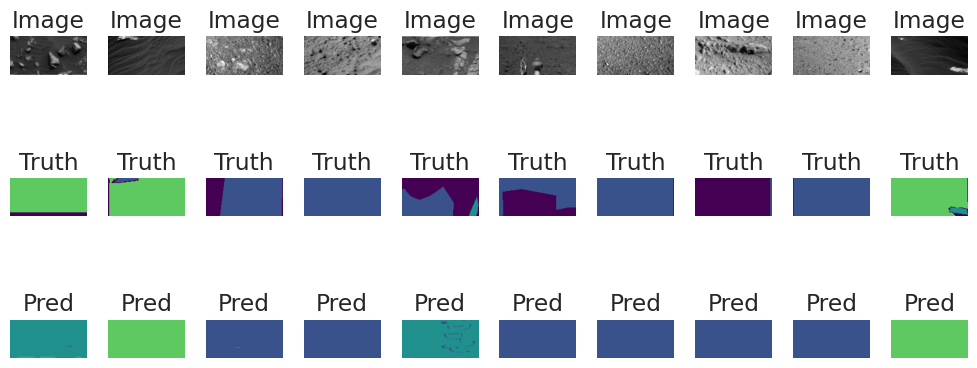


Epoch 10: val_mean_iou improved from 0.34300 to 0.37669, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 103s 174ms/step - loss: 0.8746 - mean_iou: 0.3822 - val_loss: 0.8578 - val_mean_iou: 0.3767 - learning_rate: 0.0010
Epoch 11/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.8008 - mean_iou: 0.4230
Epoch 11: val_mean_iou improved from 0.37669 to 0.44517, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 87s 155ms/step - loss: 0.8008 - mean_iou: 0.4229 - val_loss: 0.7642 - val_mean_iou: 0.4452 - learning_rate: 0.0010
Epoch 12/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.7655 - mean_iou: 0.4398
Epoch 12: val_mean_iou improved from 0.44517 to 0.44811, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 140s 151ms/step - loss: 0.7655 - mean_iou: 0.4397 - val_loss: 0.7999 - val_mean_iou: 0.4481 - learning_rate: 0.0010
Epoch 13/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0

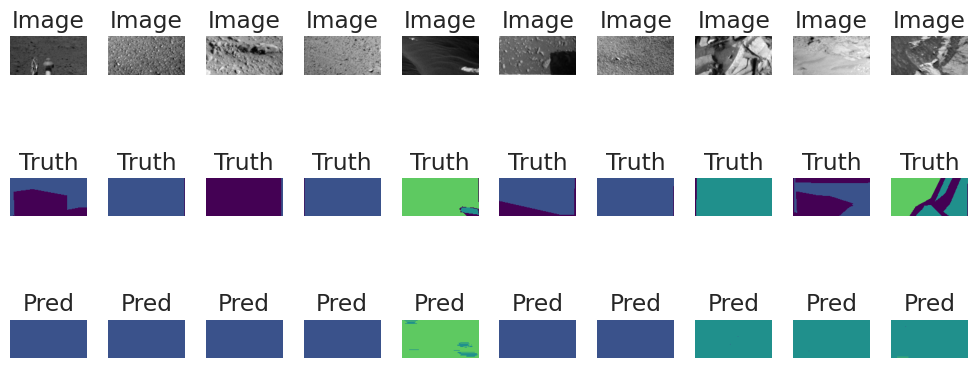


Epoch 13: val_mean_iou improved from 0.44811 to 0.46205, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 145s 157ms/step - loss: 0.7457 - mean_iou: 0.4531 - val_loss: 0.7440 - val_mean_iou: 0.4621 - learning_rate: 0.0010
Epoch 14/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.7097 - mean_iou: 0.4678
Epoch 14: val_mean_iou improved from 0.46205 to 0.47011, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 96s 171ms/step - loss: 0.7097 - mean_iou: 0.4677 - val_loss: 0.6966 - val_mean_iou: 0.4701 - learning_rate: 0.0010
Epoch 15/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.6969 - mean_iou: 0.4756
Epoch 15: val_mean_iou improved from 0.47011 to 0.49541, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 90s 160ms/step - loss: 0.6969 - mean_iou: 0.4755 - val_loss: 0.6574 - val_mean_iou: 0.4954 - learning_rate: 0.0010
Epoch 16/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s

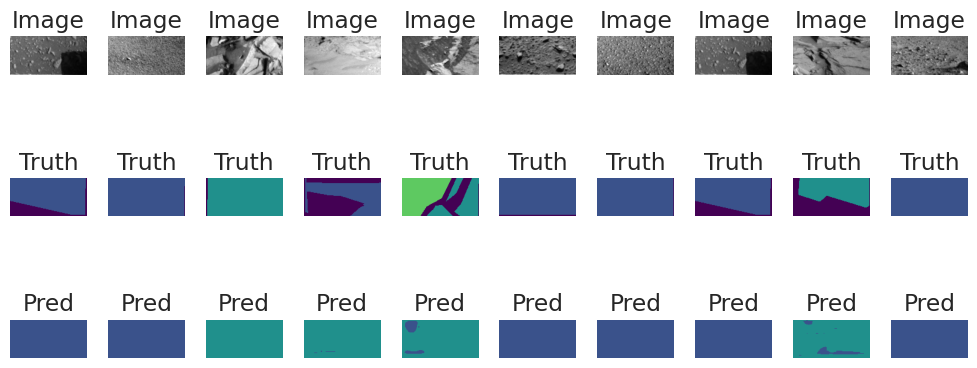


Epoch 16: val_mean_iou improved from 0.49541 to 0.50248, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 164s 198ms/step - loss: 0.6675 - mean_iou: 0.4828 - val_loss: 0.6539 - val_mean_iou: 0.5025 - learning_rate: 0.0010
Epoch 17/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.6525 - mean_iou: 0.4918
Epoch 17: val_mean_iou improved from 0.50248 to 0.53062, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 129s 176ms/step - loss: 0.6525 - mean_iou: 0.4917 - val_loss: 0.5508 - val_mean_iou: 0.5306 - learning_rate: 0.0010
Epoch 18/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.6404 - mean_iou: 0.4945
Epoch 18: val_mean_iou did not improve from 0.53062
564/564 ━━━━━━━━━━━━━━━━━━━━ 120s 137ms/step - loss: 0.6404 - mean_iou: 0.4944 - val_loss: 0.6207 - val_mean_iou: 0.5152 - learning_rate: 0.0010
Epoch 19/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.6256 - mean_iou: 0.4996

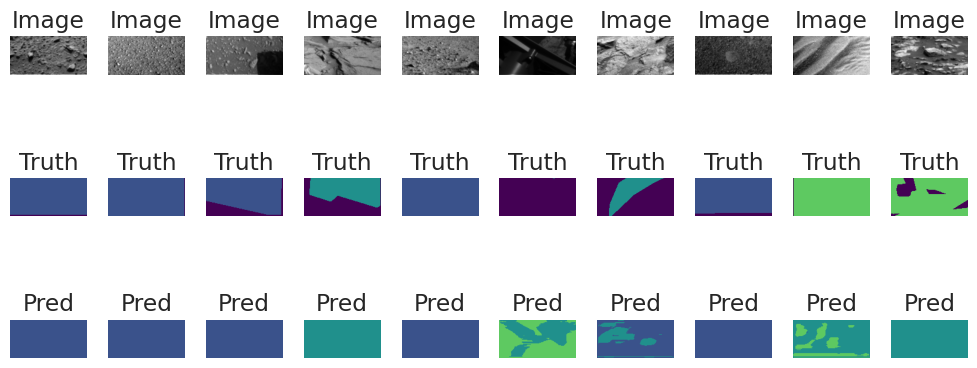


Epoch 19: val_mean_iou improved from 0.53062 to 0.53623, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 95s 160ms/step - loss: 0.6256 - mean_iou: 0.4995 - val_loss: 0.5489 - val_mean_iou: 0.5362 - learning_rate: 0.0010
Epoch 20/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.6149 - mean_iou: 0.5028
Epoch 20: val_mean_iou did not improve from 0.53623
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 139ms/step - loss: 0.6149 - mean_iou: 0.5027 - val_loss: 0.6134 - val_mean_iou: 0.5083 - learning_rate: 0.0010
Epoch 21/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.6021 - mean_iou: 0.5092
Epoch 21: val_mean_iou improved from 0.53623 to 0.53932, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 116s 200ms/step - loss: 0.6021 - mean_iou: 0.5091 - val_loss: 0.5540 - val_mean_iou: 0.5393 - learning_rate: 0.0010
Epoch 22/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.6218 - mean_iou: 0.5038

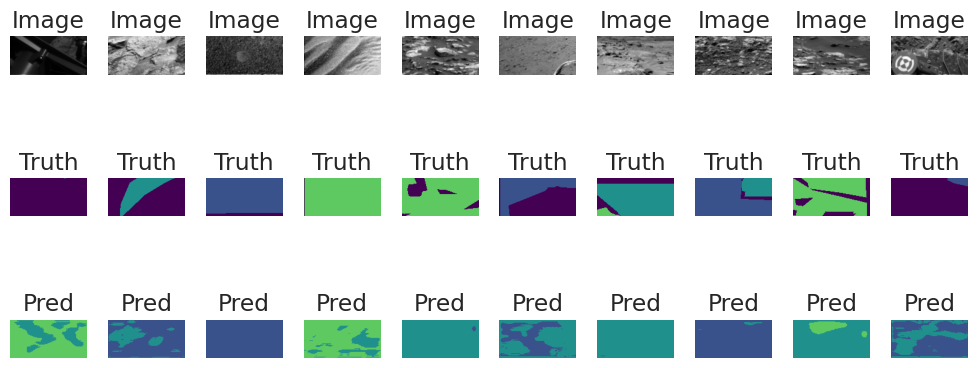


Epoch 22: val_mean_iou did not improve from 0.53932
564/564 ━━━━━━━━━━━━━━━━━━━━ 110s 143ms/step - loss: 0.6218 - mean_iou: 0.5036 - val_loss: 0.5554 - val_mean_iou: 0.5278 - learning_rate: 0.0010
Epoch 23/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.6233 - mean_iou: 0.5057
Epoch 23: val_mean_iou improved from 0.53932 to 0.54623, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 93s 165ms/step - loss: 0.6233 - mean_iou: 0.5055 - val_loss: 0.6547 - val_mean_iou: 0.5462 - learning_rate: 0.0010
Epoch 24/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.6123 - mean_iou: 0.5158
Epoch 24: val_mean_iou improved from 0.54623 to 0.56356, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 101s 178ms/step - loss: 0.6123 - mean_iou: 0.5157 - val_loss: 0.5032 - val_mean_iou: 0.5636 - learning_rate: 0.0010
Epoch 25/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5732 - mean_iou: 0.5191

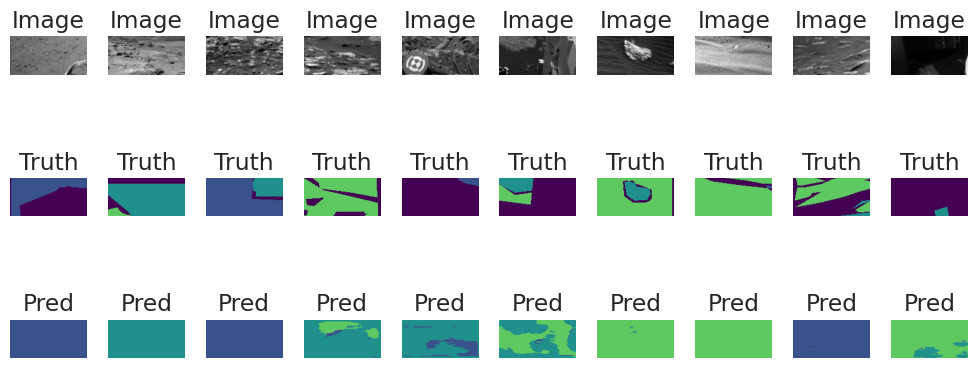


Epoch 25: val_mean_iou did not improve from 0.56356
564/564 ━━━━━━━━━━━━━━━━━━━━ 122s 144ms/step - loss: 0.5732 - mean_iou: 0.5190 - val_loss: 0.5409 - val_mean_iou: 0.5388 - learning_rate: 0.0010
Epoch 26/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5752 - mean_iou: 0.5194
Epoch 26: val_mean_iou did not improve from 0.56356
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 136ms/step - loss: 0.5752 - mean_iou: 0.5193 - val_loss: 0.5693 - val_mean_iou: 0.5368 - learning_rate: 0.0010
Epoch 27/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5940 - mean_iou: 0.5156
Epoch 27: val_mean_iou did not improve from 0.56356
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 137ms/step - loss: 0.5940 - mean_iou: 0.5155 - val_loss: 0.5056 - val_mean_iou: 0.5623 - learning_rate: 0.0010
Epoch 28/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5623 - mean_iou: 0.5237

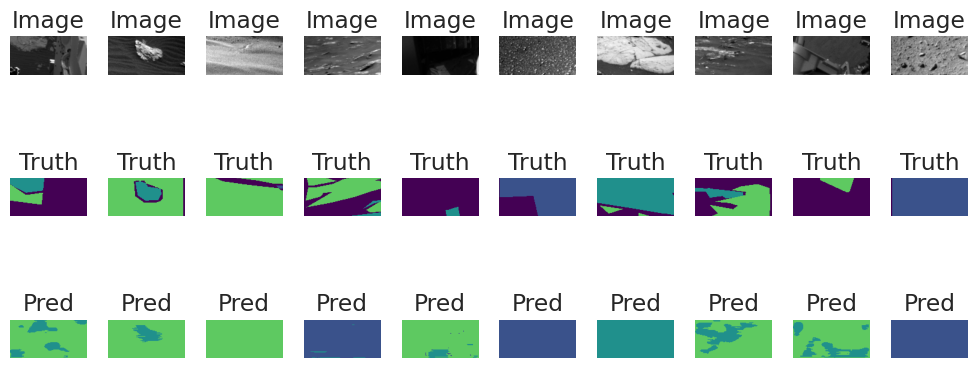


Epoch 28: val_mean_iou improved from 0.56356 to 0.57076, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 97s 163ms/step - loss: 0.5623 - mean_iou: 0.5236 - val_loss: 0.4972 - val_mean_iou: 0.5708 - learning_rate: 0.0010
Epoch 29/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.5672 - mean_iou: 0.5252
Epoch 29: val_mean_iou did not improve from 0.57076
564/564 ━━━━━━━━━━━━━━━━━━━━ 127s 137ms/step - loss: 0.5672 - mean_iou: 0.5251 - val_loss: 0.5339 - val_mean_iou: 0.5335 - learning_rate: 0.0010
Epoch 30/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5856 - mean_iou: 0.5241
Epoch 30: val_mean_iou did not improve from 0.57076
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 136ms/step - loss: 0.5856 - mean_iou: 0.5239 - val_loss: 0.5404 - val_mean_iou: 0.5376 - learning_rate: 0.0010
Epoch 31/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5668 - mean_iou: 0.5283

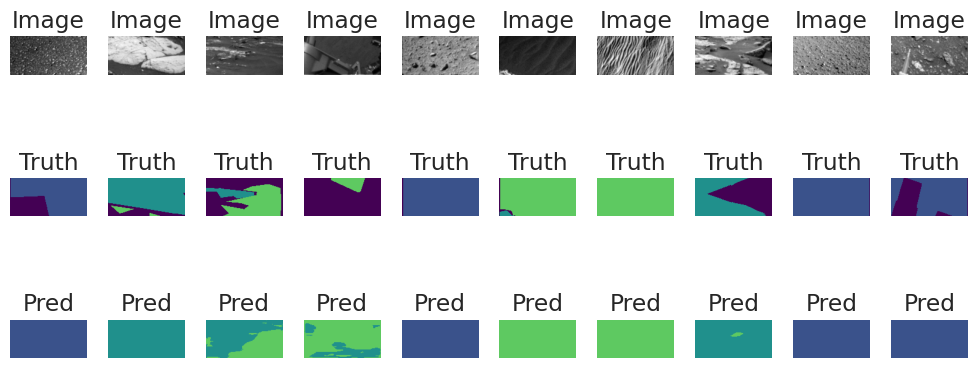


Epoch 31: val_mean_iou did not improve from 0.57076
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 142ms/step - loss: 0.5668 - mean_iou: 0.5282 - val_loss: 0.5346 - val_mean_iou: 0.5686 - learning_rate: 0.0010
Epoch 32/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5672 - mean_iou: 0.5253
Epoch 32: val_mean_iou improved from 0.57076 to 0.57516, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 87s 151ms/step - loss: 0.5672 - mean_iou: 0.5252 - val_loss: 0.4808 - val_mean_iou: 0.5752 - learning_rate: 0.0010
Epoch 33/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.5340 - mean_iou: 0.5310
Epoch 33: val_mean_iou did not improve from 0.57516
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 138ms/step - loss: 0.5340 - mean_iou: 0.5309 - val_loss: 0.4990 - val_mean_iou: 0.5600 - learning_rate: 0.0010
Epoch 34/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5654 - mean_iou: 0.5277

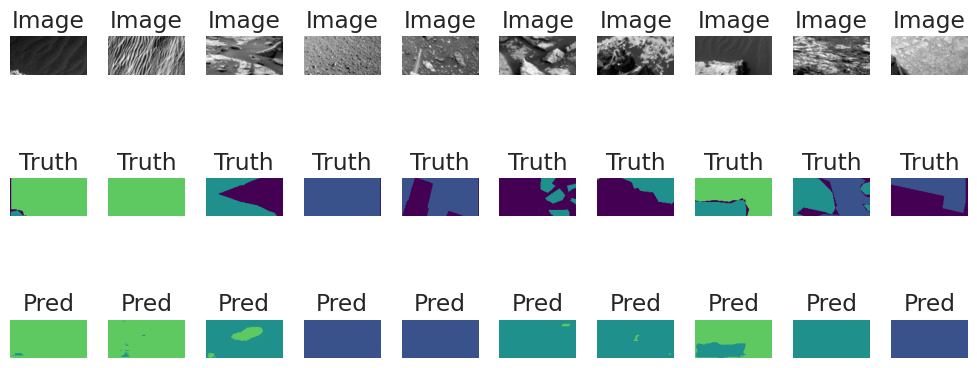


Epoch 34: val_mean_iou did not improve from 0.57516
564/564 ━━━━━━━━━━━━━━━━━━━━ 80s 142ms/step - loss: 0.5654 - mean_iou: 0.5276 - val_loss: 0.5042 - val_mean_iou: 0.5683 - learning_rate: 0.0010
Epoch 35/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5418 - mean_iou: 0.5335
Epoch 35: val_mean_iou did not improve from 0.57516
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 136ms/step - loss: 0.5418 - mean_iou: 0.5333 - val_loss: 0.4731 - val_mean_iou: 0.5667 - learning_rate: 0.0010
Epoch 36/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5350 - mean_iou: 0.5337
Epoch 36: val_mean_iou did not improve from 0.57516
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 136ms/step - loss: 0.5350 - mean_iou: 0.5336 - val_loss: 0.5729 - val_mean_iou: 0.5214 - learning_rate: 0.0010
Epoch 37/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5532 - mean_iou: 0.5274

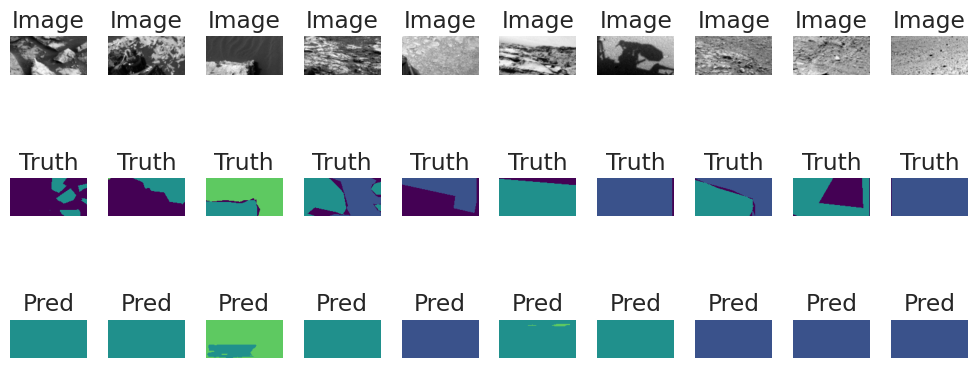


Epoch 37: val_mean_iou did not improve from 0.57516
564/564 ━━━━━━━━━━━━━━━━━━━━ 87s 144ms/step - loss: 0.5532 - mean_iou: 0.5273 - val_loss: 0.4751 - val_mean_iou: 0.5629 - learning_rate: 0.0010
Epoch 38/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5367 - mean_iou: 0.5334
Epoch 38: val_mean_iou did not improve from 0.57516
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 137ms/step - loss: 0.5368 - mean_iou: 0.5333 - val_loss: 0.5187 - val_mean_iou: 0.5531 - learning_rate: 0.0010
Epoch 39/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5433 - mean_iou: 0.5349
Epoch 39: val_mean_iou improved from 0.57516 to 0.57519, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 84s 149ms/step - loss: 0.5433 - mean_iou: 0.5348 - val_loss: 0.4557 - val_mean_iou: 0.5752 - learning_rate: 0.0010
Epoch 40/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5337 - mean_iou: 0.5390

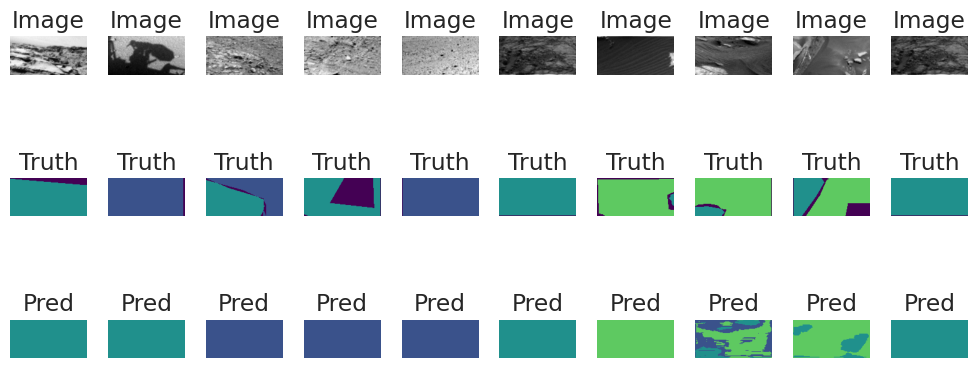


Epoch 40: val_mean_iou did not improve from 0.57519
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 143ms/step - loss: 0.5337 - mean_iou: 0.5389 - val_loss: 0.4648 - val_mean_iou: 0.5729 - learning_rate: 0.0010
Epoch 41/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5407 - mean_iou: 0.5358
Epoch 41: val_mean_iou did not improve from 0.57519
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 136ms/step - loss: 0.5407 - mean_iou: 0.5356 - val_loss: 0.5206 - val_mean_iou: 0.5562 - learning_rate: 0.0010
Epoch 42/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5261 - mean_iou: 0.5386
Epoch 42: val_mean_iou improved from 0.57519 to 0.58511, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 98s 164ms/step - loss: 0.5261 - mean_iou: 0.5385 - val_loss: 0.4387 - val_mean_iou: 0.5851 - learning_rate: 0.0010
Epoch 43/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5161 - mean_iou: 0.5424

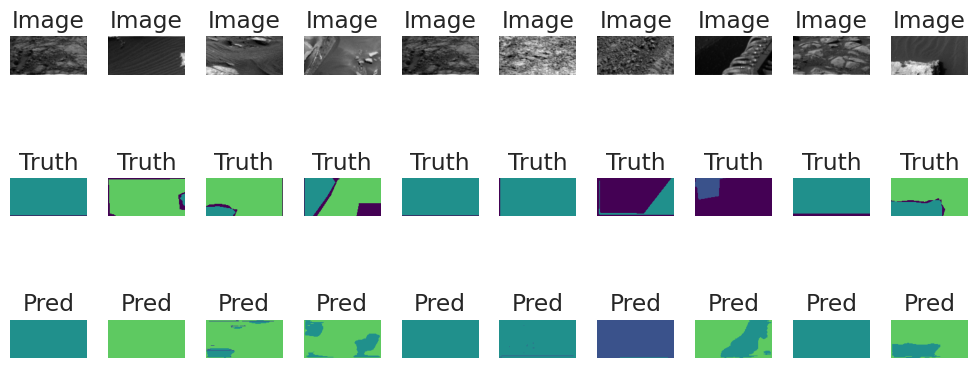


Epoch 43: val_mean_iou did not improve from 0.58511
564/564 ━━━━━━━━━━━━━━━━━━━━ 80s 142ms/step - loss: 0.5162 - mean_iou: 0.5423 - val_loss: 0.4532 - val_mean_iou: 0.5747 - learning_rate: 0.0010
Epoch 44/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5183 - mean_iou: 0.5424
Epoch 44: val_mean_iou did not improve from 0.58511
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 137ms/step - loss: 0.5183 - mean_iou: 0.5423 - val_loss: 0.4569 - val_mean_iou: 0.5721 - learning_rate: 0.0010
Epoch 45/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5255 - mean_iou: 0.5405
Epoch 45: val_mean_iou did not improve from 0.58511
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - loss: 0.5255 - mean_iou: 0.5404 - val_loss: 0.4407 - val_mean_iou: 0.5769 - learning_rate: 0.0010
Epoch 46/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5137 - mean_iou: 0.5434

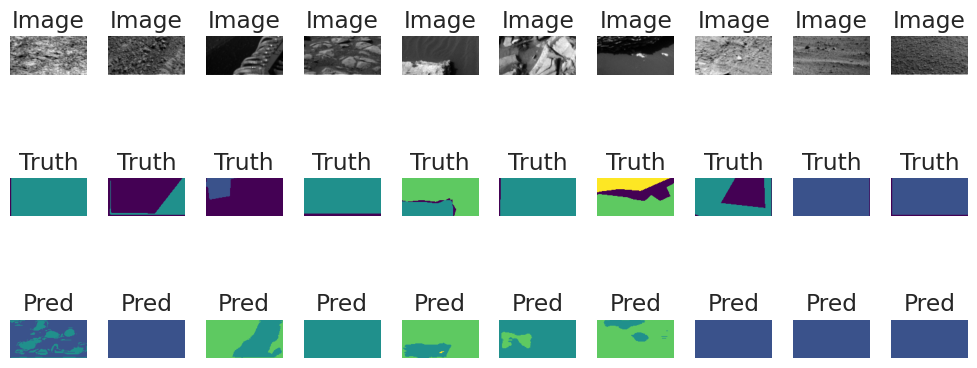


Epoch 46: val_mean_iou did not improve from 0.58511
564/564 ━━━━━━━━━━━━━━━━━━━━ 87s 146ms/step - loss: 0.5137 - mean_iou: 0.5433 - val_loss: 0.4492 - val_mean_iou: 0.5844 - learning_rate: 0.0010
Epoch 47/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5294 - mean_iou: 0.5388
Epoch 47: val_mean_iou did not improve from 0.58511
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 137ms/step - loss: 0.5294 - mean_iou: 0.5387 - val_loss: 0.4662 - val_mean_iou: 0.5851 - learning_rate: 0.0010
Epoch 48/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5140 - mean_iou: 0.5405
Epoch 48: val_mean_iou did not improve from 0.58511
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - loss: 0.5140 - mean_iou: 0.5404 - val_loss: 0.4455 - val_mean_iou: 0.5790 - learning_rate: 0.0010
Epoch 49/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5058 - mean_iou: 0.5414

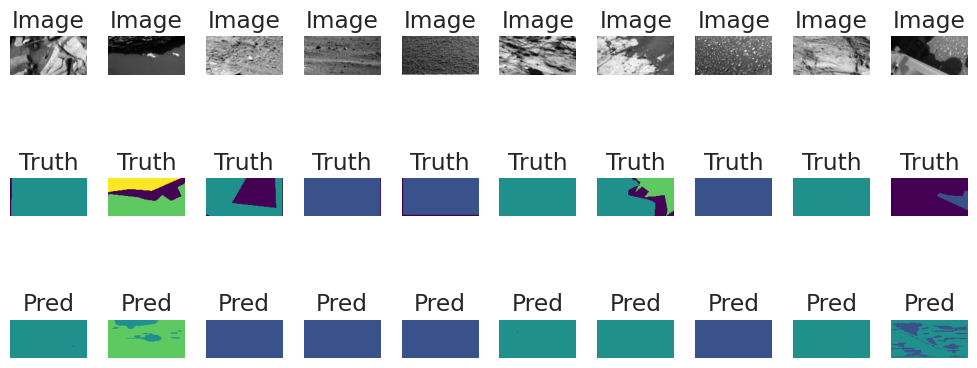


Epoch 49: val_mean_iou did not improve from 0.58511
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 142ms/step - loss: 0.5058 - mean_iou: 0.5412 - val_loss: 0.4923 - val_mean_iou: 0.5516 - learning_rate: 0.0010
Epoch 50/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5336 - mean_iou: 0.5403
Epoch 50: val_mean_iou improved from 0.58511 to 0.58524, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 97s 172ms/step - loss: 0.5336 - mean_iou: 0.5402 - val_loss: 0.4427 - val_mean_iou: 0.5852 - learning_rate: 0.0010
Epoch 51/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5148 - mean_iou: 0.5459
Epoch 51: val_mean_iou did not improve from 0.58524
564/564 ━━━━━━━━━━━━━━━━━━━━ 122s 136ms/step - loss: 0.5149 - mean_iou: 0.5458 - val_loss: 0.4829 - val_mean_iou: 0.5679 - learning_rate: 0.0010
Epoch 52/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5312 - mean_iou: 0.5401

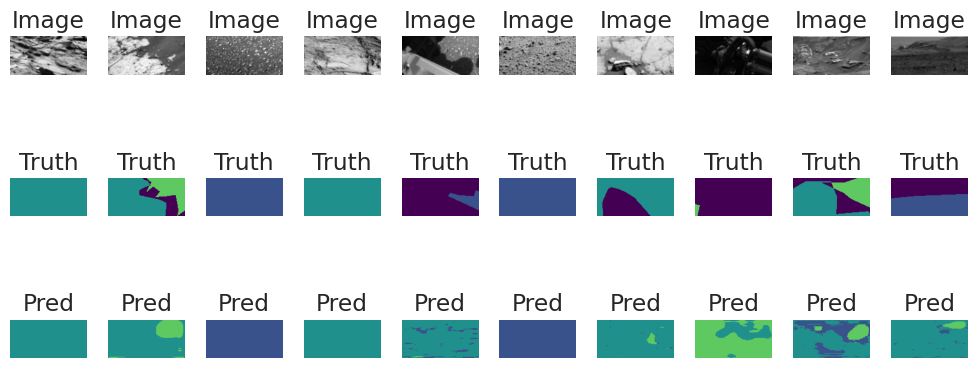


Epoch 52: val_mean_iou did not improve from 0.58524
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 142ms/step - loss: 0.5312 - mean_iou: 0.5400 - val_loss: 0.4521 - val_mean_iou: 0.5817 - learning_rate: 0.0010
Epoch 53/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5191 - mean_iou: 0.5429
Epoch 53: val_mean_iou improved from 0.58524 to 0.58848, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 94s 163ms/step - loss: 0.5191 - mean_iou: 0.5428 - val_loss: 0.4527 - val_mean_iou: 0.5885 - learning_rate: 0.0010
Epoch 54/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5126 - mean_iou: 0.5452
Epoch 54: val_mean_iou did not improve from 0.58848
564/564 ━━━━━━━━━━━━━━━━━━━━ 126s 136ms/step - loss: 0.5125 - mean_iou: 0.5451 - val_loss: 0.4341 - val_mean_iou: 0.5849 - learning_rate: 0.0010
Epoch 55/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5138 - mean_iou: 0.5429

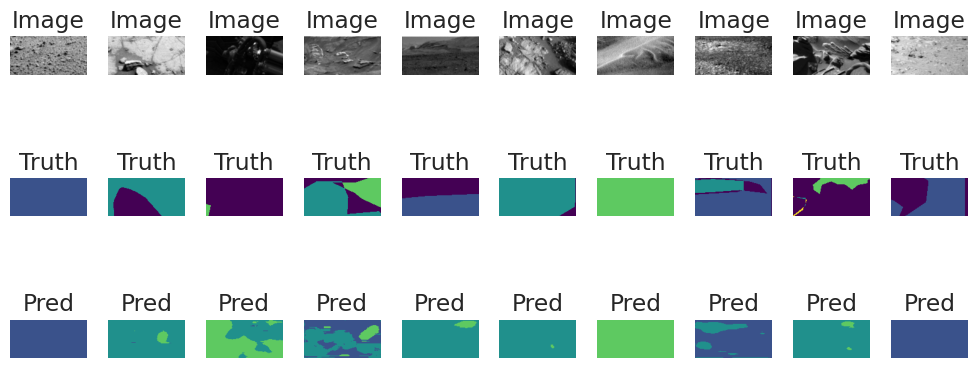


Epoch 55: val_mean_iou improved from 0.58848 to 0.59142, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 109s 185ms/step - loss: 0.5138 - mean_iou: 0.5428 - val_loss: 0.4328 - val_mean_iou: 0.5914 - learning_rate: 0.0010
Epoch 56/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.5016 - mean_iou: 0.5427
Epoch 56: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 137ms/step - loss: 0.5016 - mean_iou: 0.5426 - val_loss: 0.5941 - val_mean_iou: 0.5505 - learning_rate: 0.0010
Epoch 57/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5672 - mean_iou: 0.5457
Epoch 57: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.5671 - mean_iou: 0.5456 - val_loss: 0.5189 - val_mean_iou: 0.5506 - learning_rate: 0.0010
Epoch 58/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5243 - mean_iou: 0.5455

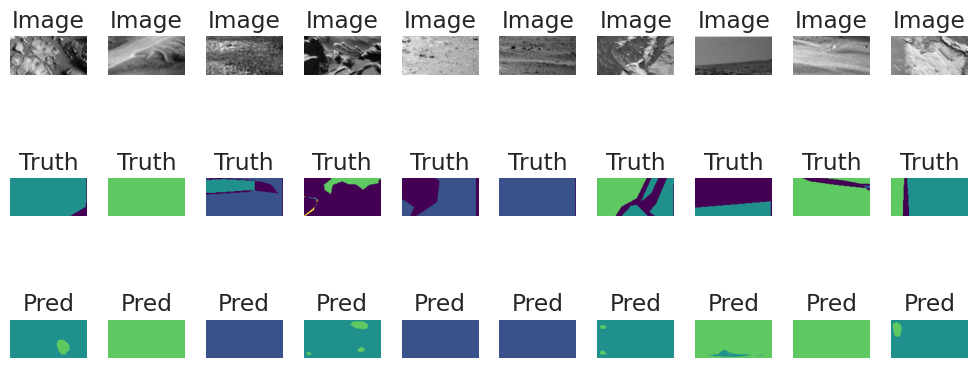


Epoch 58: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 80s 142ms/step - loss: 0.5243 - mean_iou: 0.5454 - val_loss: 0.4720 - val_mean_iou: 0.5682 - learning_rate: 0.0010
Epoch 59/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5255 - mean_iou: 0.5450
Epoch 59: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 135ms/step - loss: 0.5255 - mean_iou: 0.5449 - val_loss: 0.4565 - val_mean_iou: 0.5773 - learning_rate: 0.0010
Epoch 60/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5169 - mean_iou: 0.5482
Epoch 60: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 83s 137ms/step - loss: 0.5169 - mean_iou: 0.5481 - val_loss: 0.4498 - val_mean_iou: 0.5728 - learning_rate: 0.0010
Epoch 61/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5350 - mean_iou: 0.5435

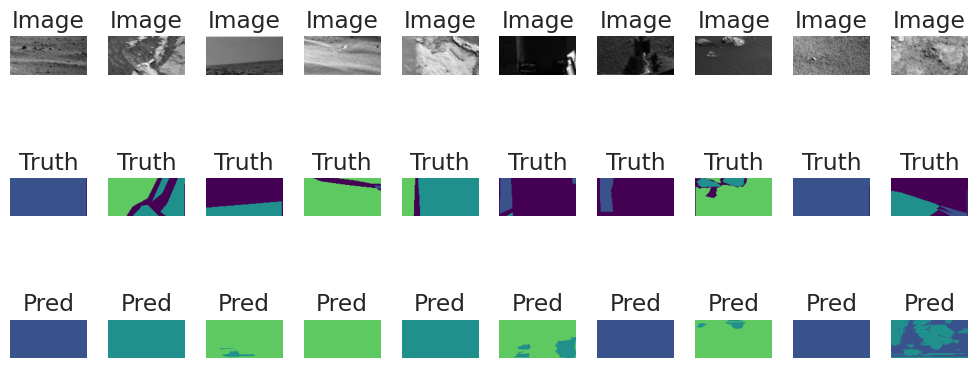


Epoch 61: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 142ms/step - loss: 0.5350 - mean_iou: 0.5434 - val_loss: 0.4379 - val_mean_iou: 0.5870 - learning_rate: 0.0010
Epoch 62/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.4927 - mean_iou: 0.5517
Epoch 62: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 136ms/step - loss: 0.4927 - mean_iou: 0.5516 - val_loss: 0.5652 - val_mean_iou: 0.5438 - learning_rate: 0.0010
Epoch 63/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5121 - mean_iou: 0.5464
Epoch 63: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - loss: 0.5122 - mean_iou: 0.5463 - val_loss: 0.4621 - val_mean_iou: 0.5848 - learning_rate: 0.0010
Epoch 64/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5008 - mean_iou: 0.5493

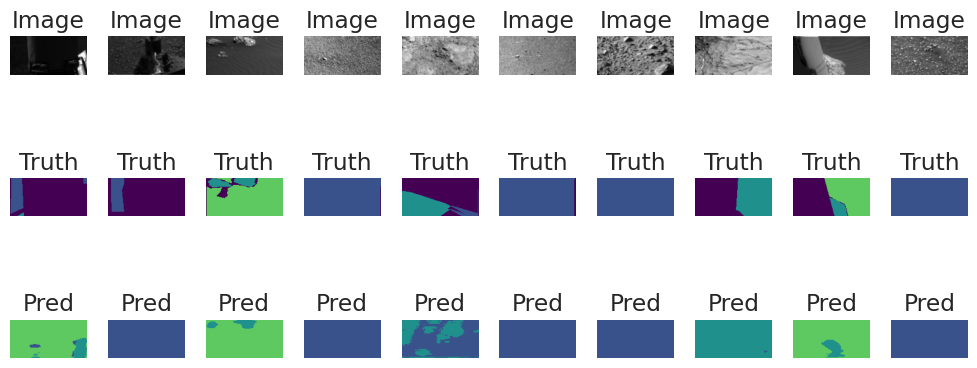


Epoch 64: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 144ms/step - loss: 0.5008 - mean_iou: 0.5492 - val_loss: 0.4647 - val_mean_iou: 0.5745 - learning_rate: 0.0010
Epoch 65/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5150 - mean_iou: 0.5472
Epoch 65: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 136ms/step - loss: 0.5150 - mean_iou: 0.5471 - val_loss: 0.5890 - val_mean_iou: 0.5217 - learning_rate: 0.0010
Epoch 66/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5192 - mean_iou: 0.5490
Epoch 66: val_mean_iou did not improve from 0.59142
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 137ms/step - loss: 0.5192 - mean_iou: 0.5489 - val_loss: 0.5393 - val_mean_iou: 0.5296 - learning_rate: 0.0010
Epoch 67/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5062 - mean_iou: 0.5458

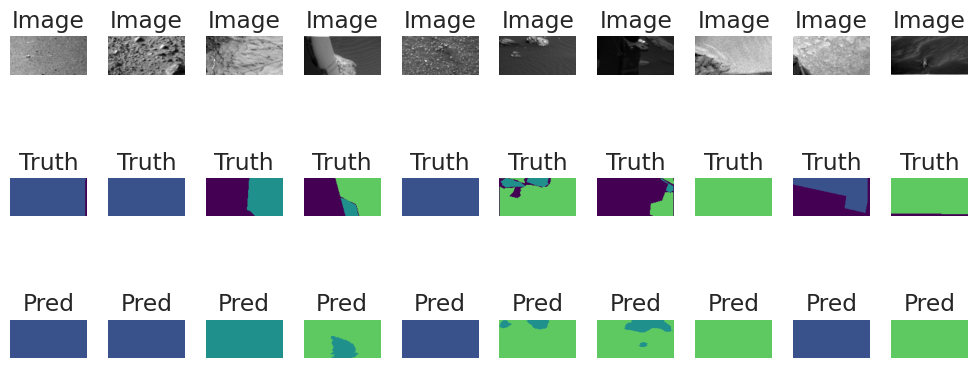


Epoch 67: val_mean_iou improved from 0.59142 to 0.59428, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 99s 176ms/step - loss: 0.5062 - mean_iou: 0.5457 - val_loss: 0.4307 - val_mean_iou: 0.5943 - learning_rate: 0.0010
Epoch 68/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.4871 - mean_iou: 0.5497
Epoch 68: val_mean_iou did not improve from 0.59428
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 137ms/step - loss: 0.4871 - mean_iou: 0.5496 - val_loss: 0.4159 - val_mean_iou: 0.5929 - learning_rate: 0.0010
Epoch 69/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.4937 - mean_iou: 0.5514
Epoch 69: val_mean_iou improved from 0.59428 to 0.59766, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 101s 170ms/step - loss: 0.4937 - mean_iou: 0.5513 - val_loss: 0.4173 - val_mean_iou: 0.5977 - learning_rate: 0.0010
Epoch 70/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5191 - mean_iou: 0.5449

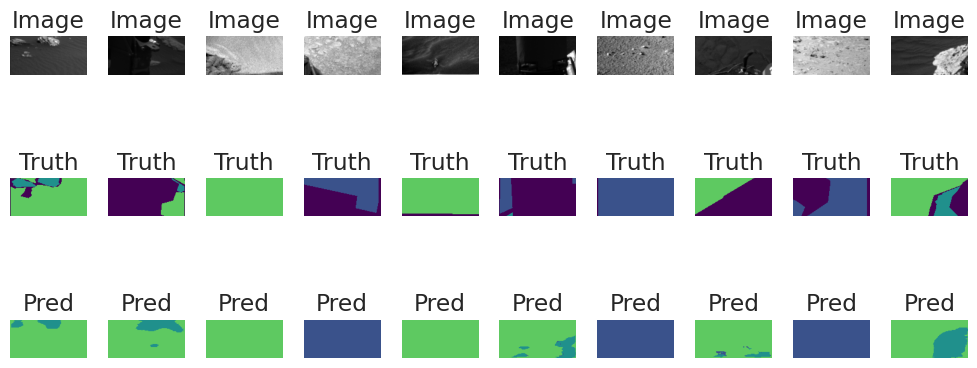


Epoch 70: val_mean_iou did not improve from 0.59766
564/564 ━━━━━━━━━━━━━━━━━━━━ 127s 143ms/step - loss: 0.5191 - mean_iou: 0.5447 - val_loss: 0.4228 - val_mean_iou: 0.5967 - learning_rate: 0.0010
Epoch 71/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5063 - mean_iou: 0.5490
Epoch 71: val_mean_iou did not improve from 0.59766
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 137ms/step - loss: 0.5063 - mean_iou: 0.5489 - val_loss: 0.4481 - val_mean_iou: 0.5833 - learning_rate: 0.0010
Epoch 72/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5071 - mean_iou: 0.5482
Epoch 72: val_mean_iou did not improve from 0.59766
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.5071 - mean_iou: 0.5481 - val_loss: 0.4338 - val_mean_iou: 0.5896 - learning_rate: 0.0010
Epoch 73/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5104 - mean_iou: 0.5459

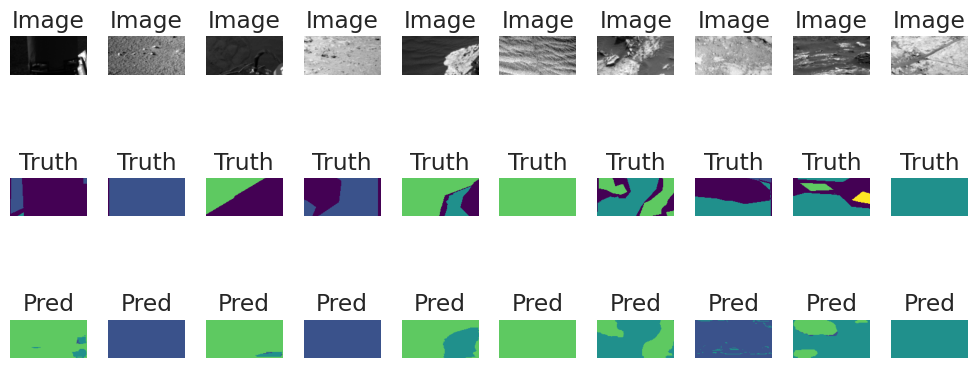


Epoch 73: val_mean_iou did not improve from 0.59766
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 143ms/step - loss: 0.5104 - mean_iou: 0.5458 - val_loss: 0.4378 - val_mean_iou: 0.5949 - learning_rate: 0.0010
Epoch 74/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.4996 - mean_iou: 0.5505
Epoch 74: val_mean_iou did not improve from 0.59766
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 135ms/step - loss: 0.4996 - mean_iou: 0.5504 - val_loss: 0.4351 - val_mean_iou: 0.5851 - learning_rate: 0.0010
Epoch 75/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.4949 - mean_iou: 0.5534
Epoch 75: val_mean_iou improved from 0.59766 to 0.60012, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 109s 184ms/step - loss: 0.4949 - mean_iou: 0.5532 - val_loss: 0.4240 - val_mean_iou: 0.6001 - learning_rate: 0.0010
Epoch 76/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.5208 - mean_iou: 0.5505

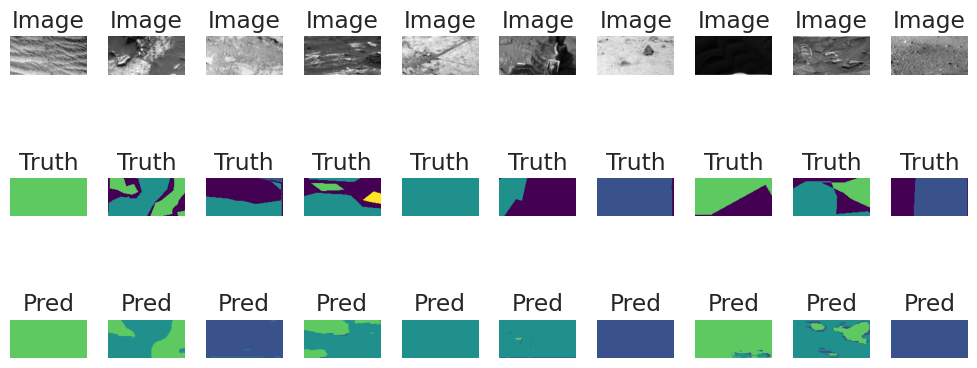


Epoch 76: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 120s 145ms/step - loss: 0.5208 - mean_iou: 0.5504 - val_loss: 0.4651 - val_mean_iou: 0.5756 - learning_rate: 0.0010
Epoch 77/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.5106 - mean_iou: 0.5518
Epoch 77: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 137s 136ms/step - loss: 0.5106 - mean_iou: 0.5516 - val_loss: 0.4606 - val_mean_iou: 0.5832 - learning_rate: 0.0010
Epoch 78/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5107 - mean_iou: 0.5478
Epoch 78: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 76s 135ms/step - loss: 0.5108 - mean_iou: 0.5477 - val_loss: 0.4831 - val_mean_iou: 0.5931 - learning_rate: 0.0010
Epoch 79/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5196 - mean_iou: 0.5512

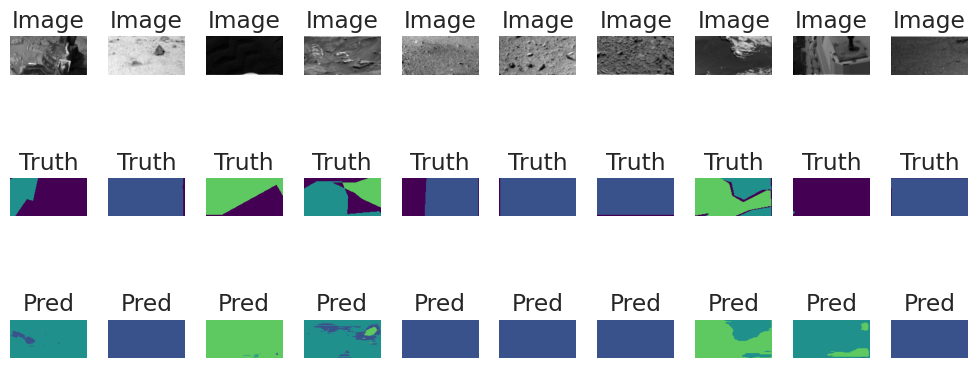


Epoch 79: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 141ms/step - loss: 0.5196 - mean_iou: 0.5511 - val_loss: 0.4472 - val_mean_iou: 0.5731 - learning_rate: 0.0010
Epoch 80/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5023 - mean_iou: 0.5502
Epoch 80: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 135ms/step - loss: 0.5023 - mean_iou: 0.5501 - val_loss: 0.4266 - val_mean_iou: 0.5927 - learning_rate: 0.0010
Epoch 81/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.5118 - mean_iou: 0.5493
Epoch 81: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 137ms/step - loss: 0.5118 - mean_iou: 0.5492 - val_loss: 0.4443 - val_mean_iou: 0.5813 - learning_rate: 0.0010
Epoch 82/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.4848 - mean_iou: 0.5515

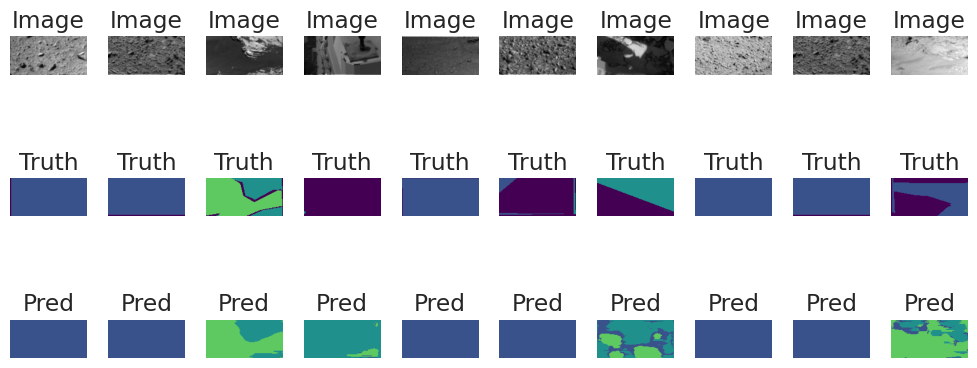


Epoch 82: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 142ms/step - loss: 0.4848 - mean_iou: 0.5514 - val_loss: 0.4865 - val_mean_iou: 0.5729 - learning_rate: 0.0010
Epoch 83/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.4877 - mean_iou: 0.5524
Epoch 83: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 135ms/step - loss: 0.4877 - mean_iou: 0.5523 - val_loss: 0.4402 - val_mean_iou: 0.5856 - learning_rate: 0.0010
Epoch 84/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.4203 - mean_iou: 0.5764
Epoch 84: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 134ms/step - loss: 0.4203 - mean_iou: 0.5763 - val_loss: 0.4022 - val_mean_iou: 0.5955 - learning_rate: 2.0000e-04
Epoch 85/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3912 - mean_iou: 0.5867

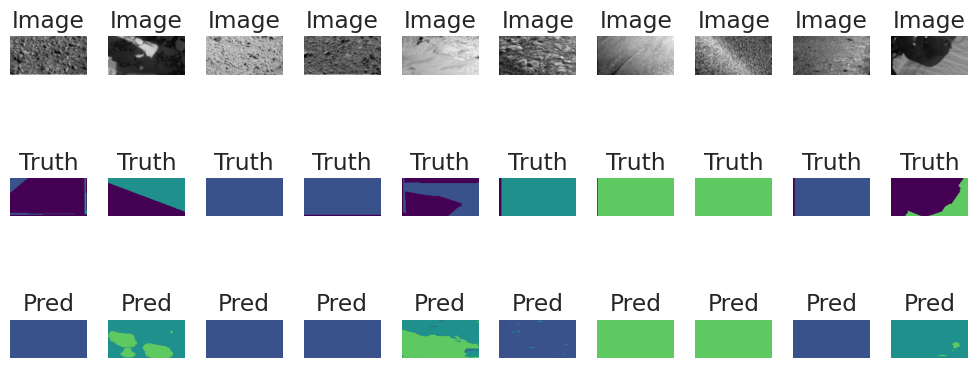


Epoch 85: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 80s 141ms/step - loss: 0.3912 - mean_iou: 0.5866 - val_loss: 0.4077 - val_mean_iou: 0.5904 - learning_rate: 2.0000e-04
Epoch 86/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3850 - mean_iou: 0.5863
Epoch 86: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 134ms/step - loss: 0.3850 - mean_iou: 0.5862 - val_loss: 0.3994 - val_mean_iou: 0.5925 - learning_rate: 2.0000e-04
Epoch 87/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3791 - mean_iou: 0.5887
Epoch 87: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 75s 134ms/step - loss: 0.3791 - mean_iou: 0.5886 - val_loss: 0.4036 - val_mean_iou: 0.5907 - learning_rate: 2.0000e-04
Epoch 88/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3754 - mean_iou: 0.5912

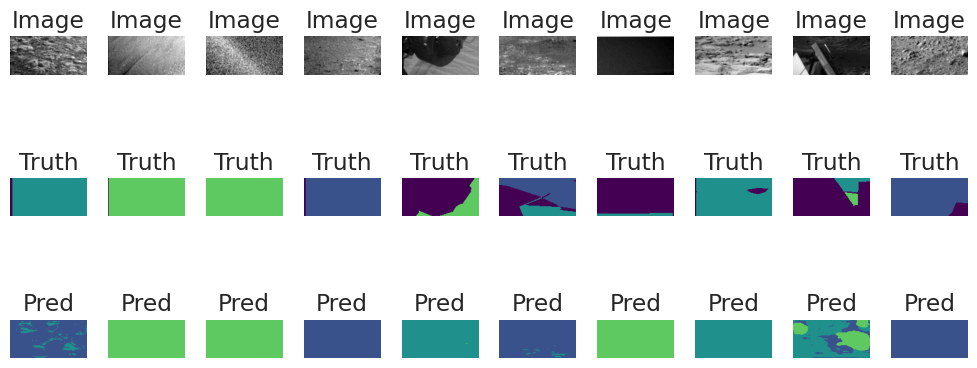


Epoch 88: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 140ms/step - loss: 0.3754 - mean_iou: 0.5911 - val_loss: 0.3975 - val_mean_iou: 0.5934 - learning_rate: 2.0000e-04
Epoch 89/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3737 - mean_iou: 0.5916
Epoch 89: val_mean_iou did not improve from 0.60012
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 134ms/step - loss: 0.3737 - mean_iou: 0.5915 - val_loss: 0.3857 - val_mean_iou: 0.5992 - learning_rate: 2.0000e-04
Epoch 90/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3645 - mean_iou: 0.5948
Epoch 90: val_mean_iou improved from 0.60012 to 0.60305, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 107s 178ms/step - loss: 0.3646 - mean_iou: 0.5947 - val_loss: 0.3832 - val_mean_iou: 0.6031 - learning_rate: 2.0000e-04
Epoch 91/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3630 - mean_iou: 0.5941

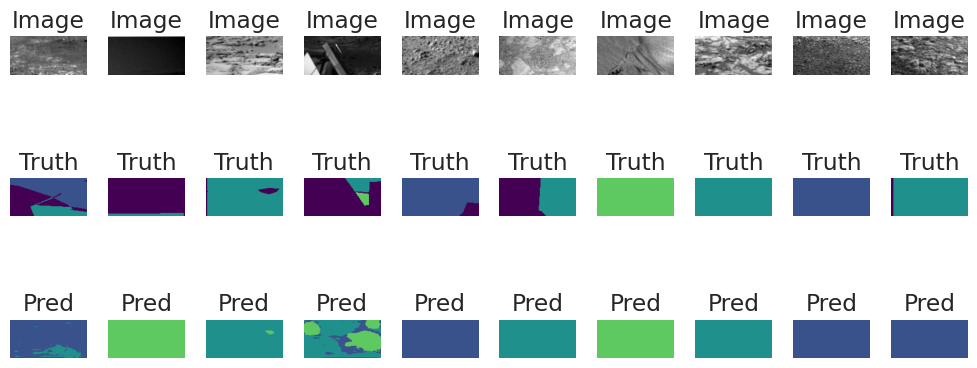


Epoch 91: val_mean_iou did not improve from 0.60305
564/564 ━━━━━━━━━━━━━━━━━━━━ 121s 141ms/step - loss: 0.3630 - mean_iou: 0.5939 - val_loss: 0.3841 - val_mean_iou: 0.5984 - learning_rate: 2.0000e-04
Epoch 92/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3602 - mean_iou: 0.5955
Epoch 92: val_mean_iou did not improve from 0.60305
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 134ms/step - loss: 0.3602 - mean_iou: 0.5953 - val_loss: 0.3813 - val_mean_iou: 0.6004 - learning_rate: 2.0000e-04
Epoch 93/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3559 - mean_iou: 0.5973
Epoch 93: val_mean_iou improved from 0.60305 to 0.60395, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 105s 174ms/step - loss: 0.3559 - mean_iou: 0.5971 - val_loss: 0.3705 - val_mean_iou: 0.6039 - learning_rate: 2.0000e-04
Epoch 94/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3520 - mean_iou: 0.5973

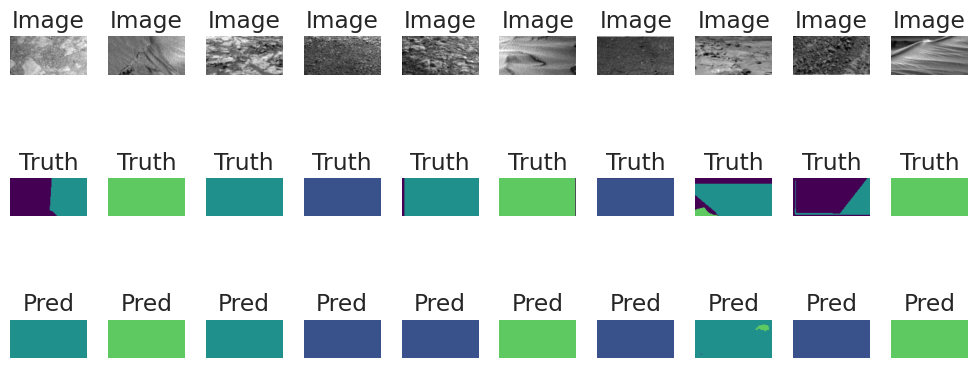


Epoch 94: val_mean_iou did not improve from 0.60395
564/564 ━━━━━━━━━━━━━━━━━━━━ 124s 142ms/step - loss: 0.3520 - mean_iou: 0.5972 - val_loss: 0.3903 - val_mean_iou: 0.5953 - learning_rate: 2.0000e-04
Epoch 95/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3508 - mean_iou: 0.5994
Epoch 95: val_mean_iou improved from 0.60395 to 0.60611, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 93s 161ms/step - loss: 0.3508 - mean_iou: 0.5993 - val_loss: 0.3659 - val_mean_iou: 0.6061 - learning_rate: 2.0000e-04
Epoch 96/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3515 - mean_iou: 0.5975
Epoch 96: val_mean_iou improved from 0.60611 to 0.60741, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 132s 143ms/step - loss: 0.3515 - mean_iou: 0.5974 - val_loss: 0.3646 - val_mean_iou: 0.6074 - learning_rate: 2.0000e-04
Epoch 97/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3467 - mean_iou: 0.5987

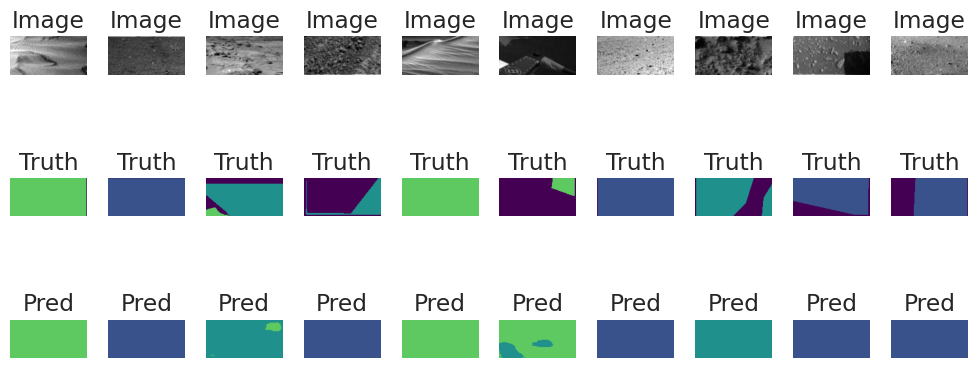


Epoch 97: val_mean_iou improved from 0.60741 to 0.61393, saving model to ./models/enrico/checkpoint/best_7.keras
564/564 ━━━━━━━━━━━━━━━━━━━━ 96s 168ms/step - loss: 0.3467 - mean_iou: 0.5986 - val_loss: 0.3579 - val_mean_iou: 0.6139 - learning_rate: 2.0000e-04
Epoch 98/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3483 - mean_iou: 0.5976
Epoch 98: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 122s 134ms/step - loss: 0.3483 - mean_iou: 0.5975 - val_loss: 0.3646 - val_mean_iou: 0.6029 - learning_rate: 2.0000e-04
Epoch 99/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3451 - mean_iou: 0.5997
Epoch 99: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - loss: 0.3451 - mean_iou: 0.5996 - val_loss: 0.3622 - val_mean_iou: 0.6061 - learning_rate: 2.0000e-04
Epoch 100/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3426 - mean_iou: 0.6005

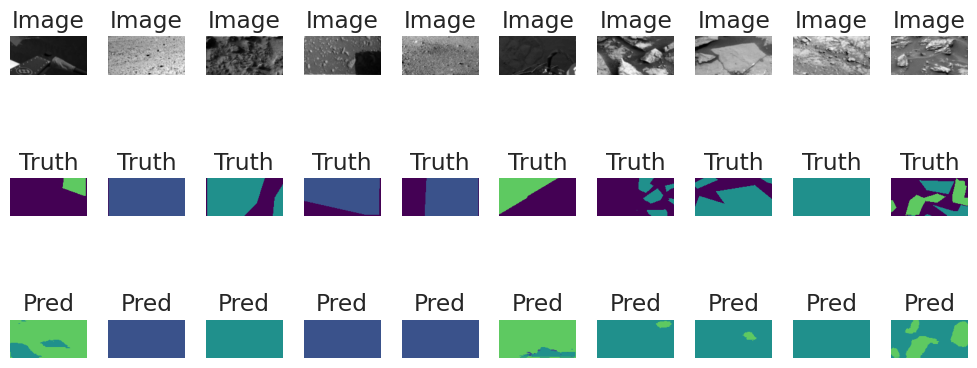


Epoch 100: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 143ms/step - loss: 0.3426 - mean_iou: 0.6003 - val_loss: 0.3781 - val_mean_iou: 0.5956 - learning_rate: 2.0000e-04
Epoch 101/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3405 - mean_iou: 0.6023
Epoch 101: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 76s 135ms/step - loss: 0.3405 - mean_iou: 0.6022 - val_loss: 0.3622 - val_mean_iou: 0.6082 - learning_rate: 2.0000e-04
Epoch 102/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3381 - mean_iou: 0.6015
Epoch 102: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 75s 134ms/step - loss: 0.3381 - mean_iou: 0.6014 - val_loss: 0.3812 - val_mean_iou: 0.5973 - learning_rate: 2.0000e-04
Epoch 103/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3371 - mean_iou: 0.6020

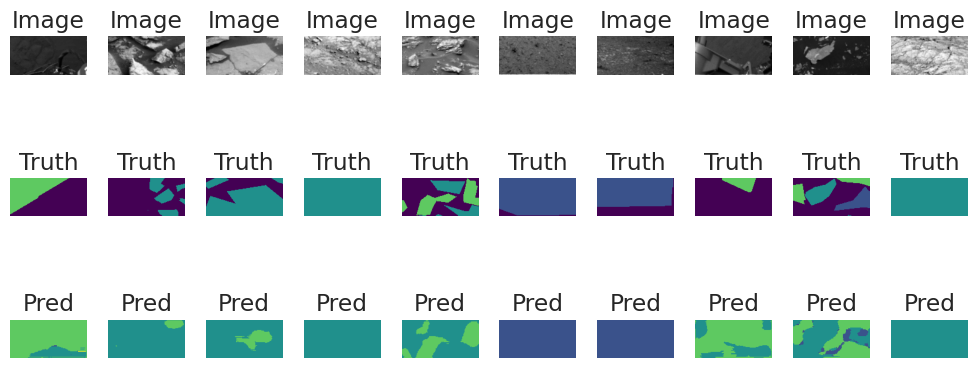


Epoch 103: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 142ms/step - loss: 0.3371 - mean_iou: 0.6019 - val_loss: 0.3617 - val_mean_iou: 0.6056 - learning_rate: 2.0000e-04
Epoch 104/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3394 - mean_iou: 0.5989
Epoch 104: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 134ms/step - loss: 0.3394 - mean_iou: 0.5988 - val_loss: 0.3616 - val_mean_iou: 0.6023 - learning_rate: 2.0000e-04
Epoch 105/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3363 - mean_iou: 0.6008
Epoch 105: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 135ms/step - loss: 0.3363 - mean_iou: 0.6007 - val_loss: 0.3822 - val_mean_iou: 0.5937 - learning_rate: 2.0000e-04
Epoch 106/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3328 - mean_iou: 0.6041

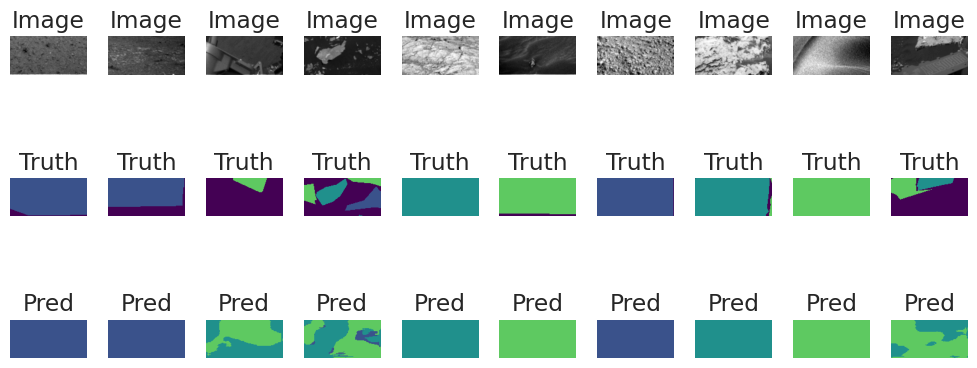


Epoch 106: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 142ms/step - loss: 0.3328 - mean_iou: 0.6040 - val_loss: 0.4009 - val_mean_iou: 0.5884 - learning_rate: 2.0000e-04
Epoch 107/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3368 - mean_iou: 0.6030
Epoch 107: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 134ms/step - loss: 0.3368 - mean_iou: 0.6029 - val_loss: 0.3556 - val_mean_iou: 0.6065 - learning_rate: 2.0000e-04
Epoch 108/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3411 - mean_iou: 0.5985
Epoch 108: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 83s 136ms/step - loss: 0.3411 - mean_iou: 0.5984 - val_loss: 0.3916 - val_mean_iou: 0.5888 - learning_rate: 2.0000e-04
Epoch 109/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3354 - mean_iou: 0.6009

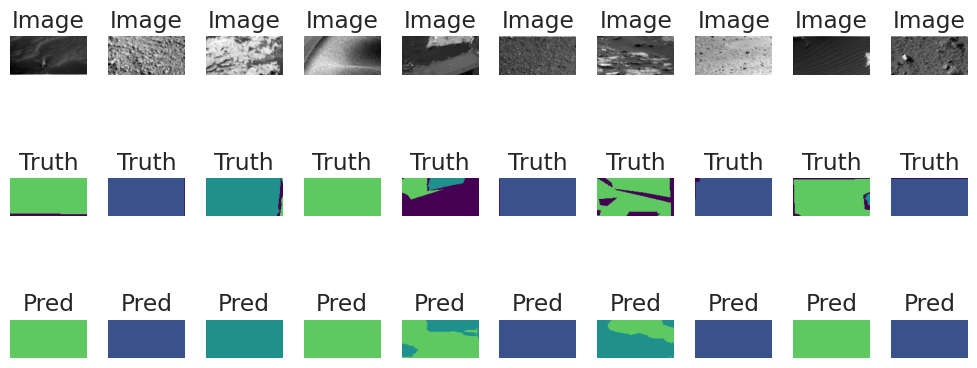


Epoch 109: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 141ms/step - loss: 0.3354 - mean_iou: 0.6008 - val_loss: 0.3717 - val_mean_iou: 0.5932 - learning_rate: 2.0000e-04
Epoch 110/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3320 - mean_iou: 0.6023
Epoch 110: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 76s 135ms/step - loss: 0.3320 - mean_iou: 0.6022 - val_loss: 0.4029 - val_mean_iou: 0.5823 - learning_rate: 2.0000e-04
Epoch 111/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3289 - mean_iou: 0.6023
Epoch 111: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - loss: 0.3289 - mean_iou: 0.6022 - val_loss: 0.3699 - val_mean_iou: 0.6002 - learning_rate: 2.0000e-04
Epoch 112/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3276 - mean_iou: 0.6058

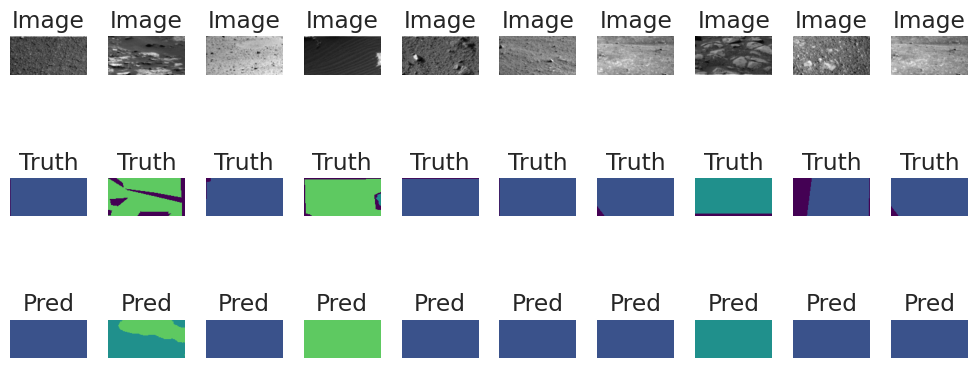


Epoch 112: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 141ms/step - loss: 0.3276 - mean_iou: 0.6057 - val_loss: 0.3860 - val_mean_iou: 0.5965 - learning_rate: 2.0000e-04
Epoch 113/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3327 - mean_iou: 0.6012
Epoch 113: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 135ms/step - loss: 0.3327 - mean_iou: 0.6011 - val_loss: 0.3772 - val_mean_iou: 0.5979 - learning_rate: 2.0000e-04
Epoch 114/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3272 - mean_iou: 0.6036
Epoch 114: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 134ms/step - loss: 0.3272 - mean_iou: 0.6035 - val_loss: 0.3669 - val_mean_iou: 0.6034 - learning_rate: 2.0000e-04
Epoch 115/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3256 - mean_iou: 0.6055

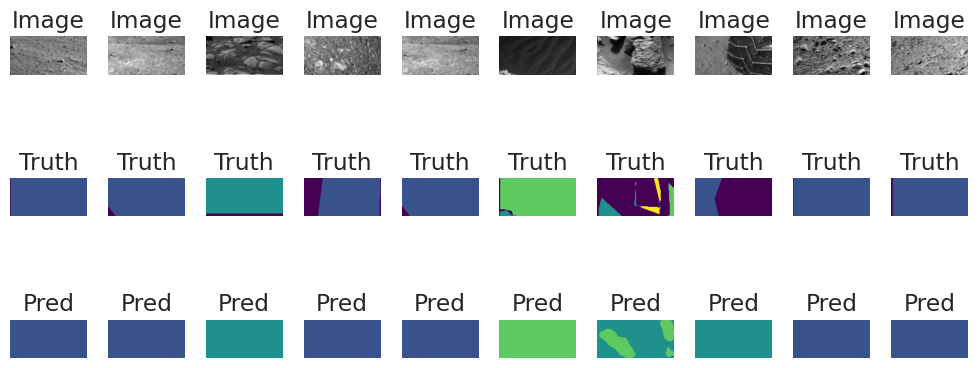


Epoch 115: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 87s 142ms/step - loss: 0.3256 - mean_iou: 0.6054 - val_loss: 0.3848 - val_mean_iou: 0.5976 - learning_rate: 2.0000e-04
Epoch 116/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3275 - mean_iou: 0.6034
Epoch 116: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 134ms/step - loss: 0.3275 - mean_iou: 0.6033 - val_loss: 0.3644 - val_mean_iou: 0.5996 - learning_rate: 2.0000e-04
Epoch 117/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3251 - mean_iou: 0.6063
Epoch 117: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - loss: 0.3251 - mean_iou: 0.6062 - val_loss: 0.3710 - val_mean_iou: 0.6019 - learning_rate: 2.0000e-04
Epoch 118/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3284 - mean_iou: 0.6039

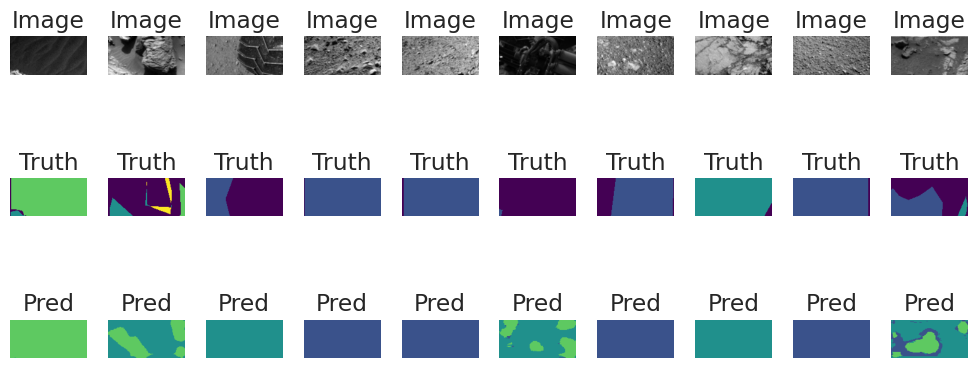


Epoch 118: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 85s 139ms/step - loss: 0.3284 - mean_iou: 0.6038 - val_loss: 0.3786 - val_mean_iou: 0.5958 - learning_rate: 2.0000e-04
Epoch 119/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3278 - mean_iou: 0.6029
Epoch 119: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 80s 135ms/step - loss: 0.3278 - mean_iou: 0.6028 - val_loss: 0.3661 - val_mean_iou: 0.5986 - learning_rate: 2.0000e-04
Epoch 120/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3219 - mean_iou: 0.6067
Epoch 120: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 134ms/step - loss: 0.3219 - mean_iou: 0.6066 - val_loss: 0.3616 - val_mean_iou: 0.6045 - learning_rate: 2.0000e-04
Epoch 121/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3249 - mean_iou: 0.6051

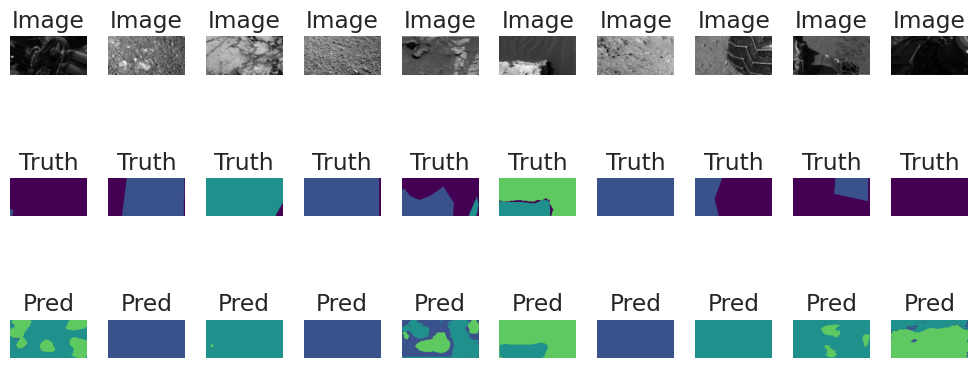


Epoch 121: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 139ms/step - loss: 0.3249 - mean_iou: 0.6050 - val_loss: 0.3960 - val_mean_iou: 0.5889 - learning_rate: 2.0000e-04
Epoch 122/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3216 - mean_iou: 0.6066
Epoch 122: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - loss: 0.3216 - mean_iou: 0.6065 - val_loss: 0.4197 - val_mean_iou: 0.5883 - learning_rate: 2.0000e-04
Epoch 123/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3186 - mean_iou: 0.6070
Epoch 123: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 75s 134ms/step - loss: 0.3186 - mean_iou: 0.6069 - val_loss: 0.3694 - val_mean_iou: 0.6033 - learning_rate: 2.0000e-04
Epoch 124/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3227 - mean_iou: 0.6068

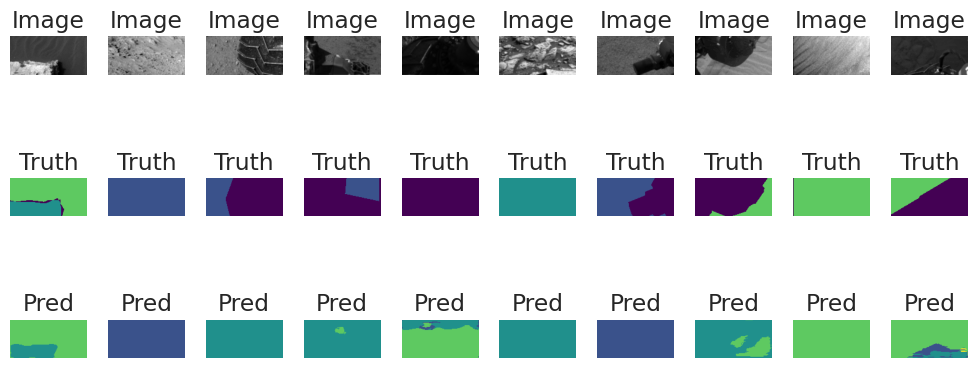


Epoch 124: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 140ms/step - loss: 0.3227 - mean_iou: 0.6067 - val_loss: 0.3601 - val_mean_iou: 0.6110 - learning_rate: 2.0000e-04
Epoch 125/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3193 - mean_iou: 0.6082
Epoch 125: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 133ms/step - loss: 0.3193 - mean_iou: 0.6081 - val_loss: 0.3951 - val_mean_iou: 0.5963 - learning_rate: 2.0000e-04
Epoch 126/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3166 - mean_iou: 0.6096
Epoch 126: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 75s 134ms/step - loss: 0.3166 - mean_iou: 0.6094 - val_loss: 0.3826 - val_mean_iou: 0.5972 - learning_rate: 2.0000e-04
Epoch 127/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3168 - mean_iou: 0.6080

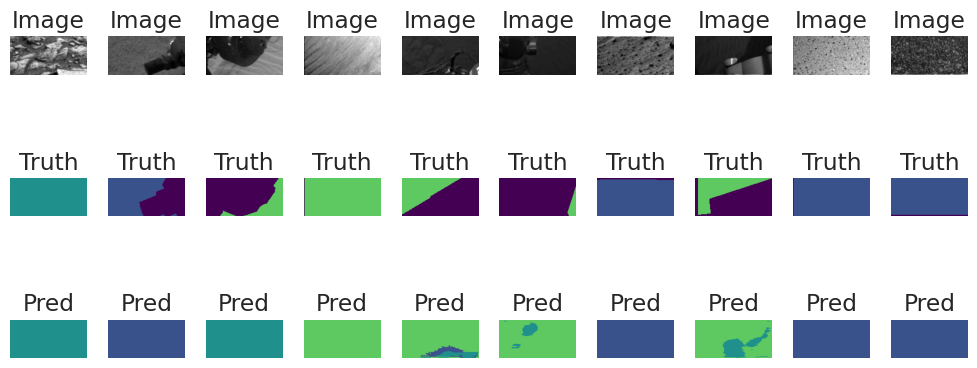


Epoch 127: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 142ms/step - loss: 0.3168 - mean_iou: 0.6079 - val_loss: 0.3809 - val_mean_iou: 0.5976 - learning_rate: 2.0000e-04
Epoch 128/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3244 - mean_iou: 0.6069
Epoch 128: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 134ms/step - loss: 0.3244 - mean_iou: 0.6068 - val_loss: 0.3719 - val_mean_iou: 0.6009 - learning_rate: 2.0000e-04
Epoch 129/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3257 - mean_iou: 0.6052
Epoch 129: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 75s 134ms/step - loss: 0.3257 - mean_iou: 0.6051 - val_loss: 0.4040 - val_mean_iou: 0.5853 - learning_rate: 2.0000e-04
Epoch 130/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3164 - mean_iou: 0.6103

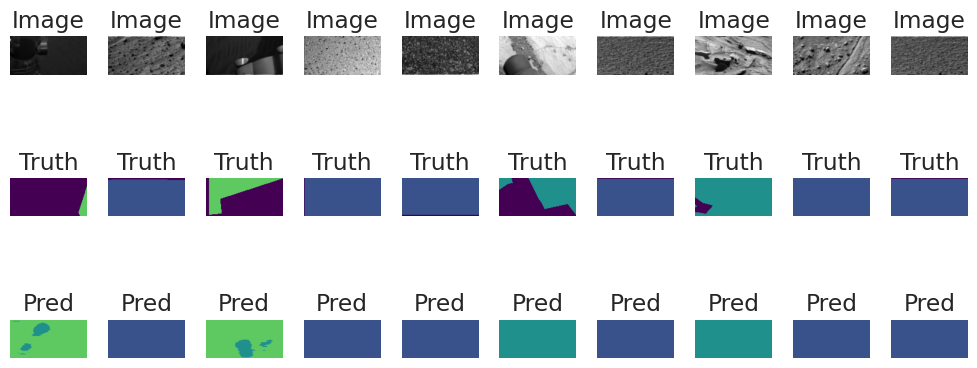


Epoch 130: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 140ms/step - loss: 0.3164 - mean_iou: 0.6101 - val_loss: 0.3864 - val_mean_iou: 0.5881 - learning_rate: 2.0000e-04
Epoch 131/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3191 - mean_iou: 0.6065
Epoch 131: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 134ms/step - loss: 0.3191 - mean_iou: 0.6064 - val_loss: 0.3844 - val_mean_iou: 0.5891 - learning_rate: 2.0000e-04
Epoch 132/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3110 - mean_iou: 0.6121
Epoch 132: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 83s 135ms/step - loss: 0.3110 - mean_iou: 0.6120 - val_loss: 0.3880 - val_mean_iou: 0.5921 - learning_rate: 2.0000e-04
Epoch 133/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3216 - mean_iou: 0.6065

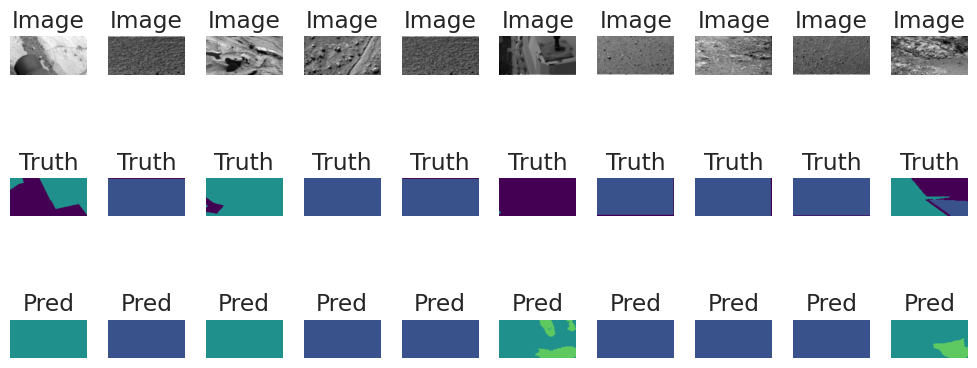


Epoch 133: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 143ms/step - loss: 0.3216 - mean_iou: 0.6064 - val_loss: 0.4061 - val_mean_iou: 0.5839 - learning_rate: 2.0000e-04
Epoch 134/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3121 - mean_iou: 0.6112
Epoch 134: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 134ms/step - loss: 0.3121 - mean_iou: 0.6111 - val_loss: 0.3946 - val_mean_iou: 0.5838 - learning_rate: 2.0000e-04
Epoch 135/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3152 - mean_iou: 0.6095
Epoch 135: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - loss: 0.3152 - mean_iou: 0.6094 - val_loss: 0.3772 - val_mean_iou: 0.5988 - learning_rate: 2.0000e-04
Epoch 136/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3193 - mean_iou: 0.6081

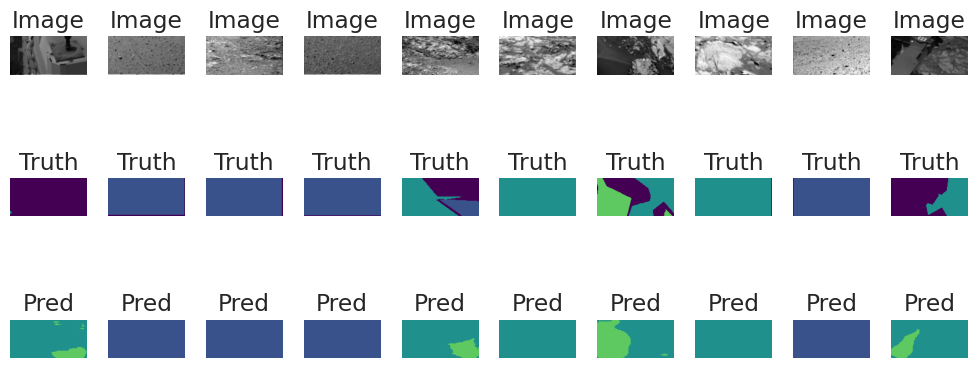


Epoch 136: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 140ms/step - loss: 0.3193 - mean_iou: 0.6080 - val_loss: 0.4273 - val_mean_iou: 0.5843 - learning_rate: 2.0000e-04
Epoch 137/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3144 - mean_iou: 0.6116
Epoch 137: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 134ms/step - loss: 0.3144 - mean_iou: 0.6115 - val_loss: 0.4111 - val_mean_iou: 0.5894 - learning_rate: 2.0000e-04
Epoch 138/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3115 - mean_iou: 0.6114
Epoch 138: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - loss: 0.3115 - mean_iou: 0.6113 - val_loss: 0.3624 - val_mean_iou: 0.6124 - learning_rate: 2.0000e-04
Epoch 139/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3222 - mean_iou: 0.6044

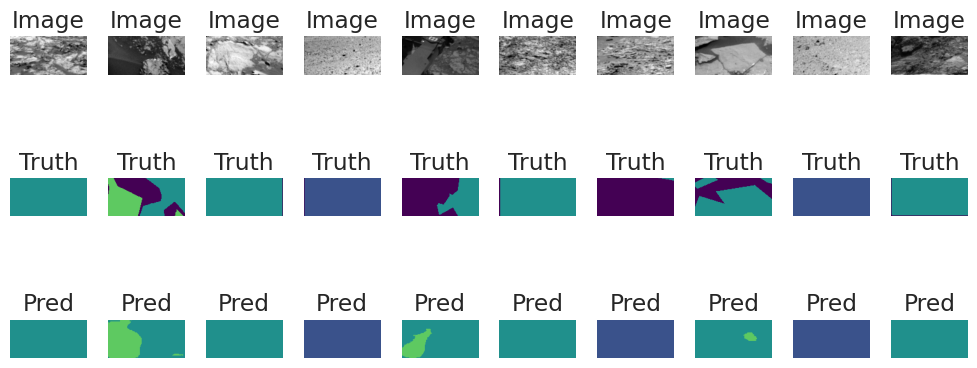


Epoch 139: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 139ms/step - loss: 0.3222 - mean_iou: 0.6043 - val_loss: 0.4403 - val_mean_iou: 0.5782 - learning_rate: 2.0000e-04
Epoch 140/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3161 - mean_iou: 0.6089
Epoch 140: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - loss: 0.3161 - mean_iou: 0.6087 - val_loss: 0.3485 - val_mean_iou: 0.6135 - learning_rate: 2.0000e-04
Epoch 141/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3138 - mean_iou: 0.6106
Epoch 141: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - loss: 0.3138 - mean_iou: 0.6105 - val_loss: 0.4128 - val_mean_iou: 0.5765 - learning_rate: 2.0000e-04
Epoch 142/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3105 - mean_iou: 0.6123

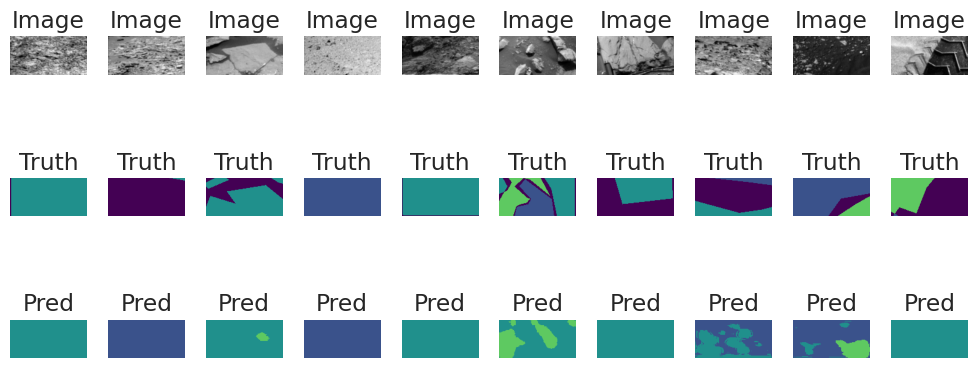


Epoch 142: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 87s 143ms/step - loss: 0.3105 - mean_iou: 0.6122 - val_loss: 0.4263 - val_mean_iou: 0.5812 - learning_rate: 2.0000e-04
Epoch 143/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3128 - mean_iou: 0.6110
Epoch 143: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 77s 134ms/step - loss: 0.3128 - mean_iou: 0.6109 - val_loss: 0.4026 - val_mean_iou: 0.5936 - learning_rate: 2.0000e-04
Epoch 144/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3157 - mean_iou: 0.6093
Epoch 144: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 135ms/step - loss: 0.3158 - mean_iou: 0.6092 - val_loss: 0.4404 - val_mean_iou: 0.5844 - learning_rate: 2.0000e-04
Epoch 145/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3233 - mean_iou: 0.6058

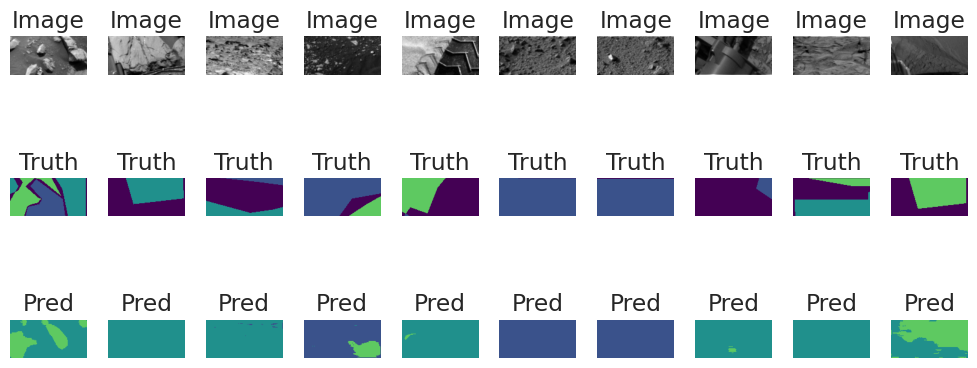


Epoch 145: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 141ms/step - loss: 0.3233 - mean_iou: 0.6057 - val_loss: 0.3974 - val_mean_iou: 0.5941 - learning_rate: 2.0000e-04
Epoch 146/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3106 - mean_iou: 0.6133
Epoch 146: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 78s 134ms/step - loss: 0.3106 - mean_iou: 0.6132 - val_loss: 0.3757 - val_mean_iou: 0.6064 - learning_rate: 2.0000e-04
Epoch 147/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3139 - mean_iou: 0.6133
Epoch 147: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 134ms/step - loss: 0.3139 - mean_iou: 0.6131 - val_loss: 0.4049 - val_mean_iou: 0.5869 - learning_rate: 2.0000e-04
Epoch 148/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3155 - mean_iou: 0.6094

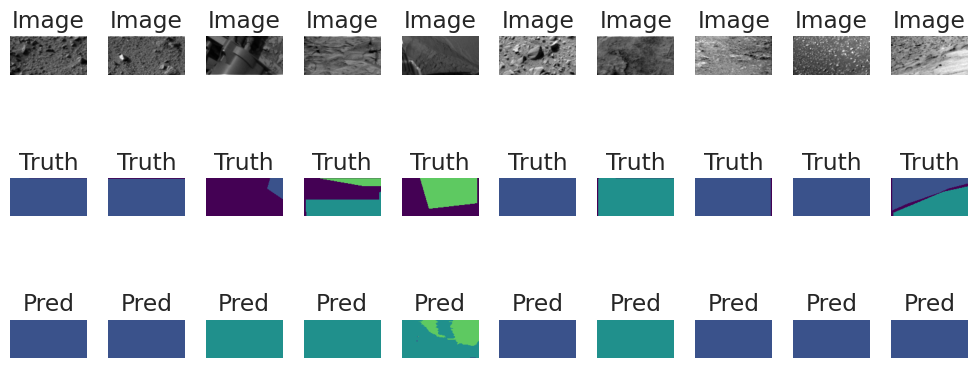


Epoch 148: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 141ms/step - loss: 0.3155 - mean_iou: 0.6093 - val_loss: 0.4110 - val_mean_iou: 0.5862 - learning_rate: 2.0000e-04
Epoch 149/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3081 - mean_iou: 0.6147
Epoch 149: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 135ms/step - loss: 0.3081 - mean_iou: 0.6146 - val_loss: 0.3955 - val_mean_iou: 0.5936 - learning_rate: 2.0000e-04
Epoch 150/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3111 - mean_iou: 0.6105
Epoch 150: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 82s 135ms/step - loss: 0.3111 - mean_iou: 0.6104 - val_loss: 0.4289 - val_mean_iou: 0.5781 - learning_rate: 2.0000e-04
Epoch 151/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3090 - mean_iou: 0.6137

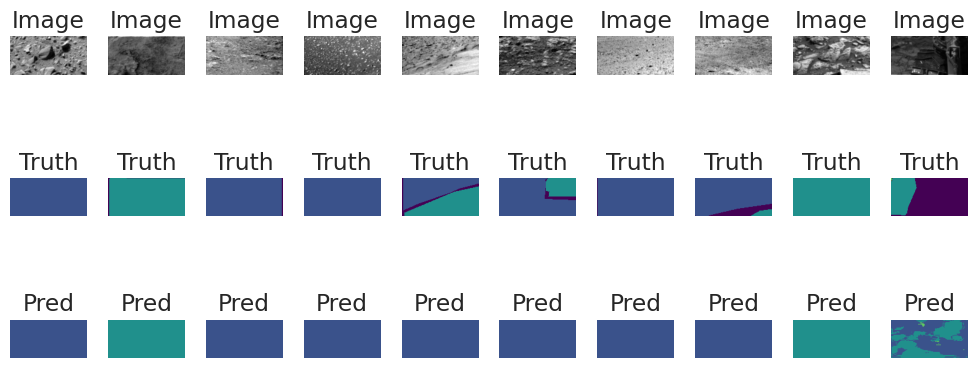


Epoch 151: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 140ms/step - loss: 0.3090 - mean_iou: 0.6136 - val_loss: 0.3922 - val_mean_iou: 0.5966 - learning_rate: 2.0000e-04
Epoch 152/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3081 - mean_iou: 0.6131
Epoch 152: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 135ms/step - loss: 0.3081 - mean_iou: 0.6130 - val_loss: 0.3613 - val_mean_iou: 0.6074 - learning_rate: 2.0000e-04
Epoch 153/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3127 - mean_iou: 0.6097
Epoch 153: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 134ms/step - loss: 0.3127 - mean_iou: 0.6096 - val_loss: 0.4470 - val_mean_iou: 0.5702 - learning_rate: 2.0000e-04
Epoch 154/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3091 - mean_iou: 0.6144

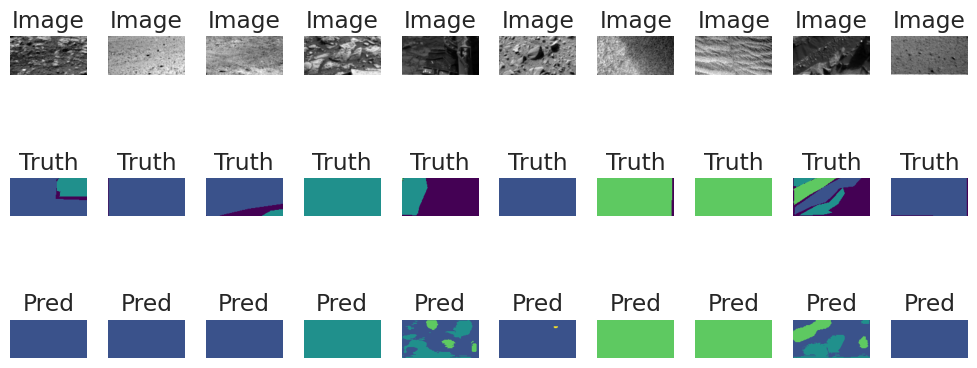


Epoch 154: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 86s 140ms/step - loss: 0.3091 - mean_iou: 0.6143 - val_loss: 0.3720 - val_mean_iou: 0.6054 - learning_rate: 2.0000e-04
Epoch 155/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.3219 - mean_iou: 0.6064
Epoch 155: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 79s 136ms/step - loss: 0.3219 - mean_iou: 0.6063 - val_loss: 0.3936 - val_mean_iou: 0.5961 - learning_rate: 2.0000e-04
Epoch 156/1000
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.3090 - mean_iou: 0.6114
Epoch 156: val_mean_iou did not improve from 0.61393
564/564 ━━━━━━━━━━━━━━━━━━━━ 81s 135ms/step - loss: 0.3090 - mean_iou: 0.6113 - val_loss: 0.3641 - val_mean_iou: 0.6048 - learning_rate: 2.0000e-04
Epoch 157/1000
132/564 ━━━━━━━━━━━━━━━━━━━━ 56s 132ms/step - loss: 0.3051 - mean_iou: 0.6340

In [ ]:
# Train the model
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping, viz_callback, reduce_lr_on_plateau, save_checkpoint],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"{home_path}/weights/en_net_{ID}_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")